In [1]:
# Imports
import sys
sys.path.insert(1, '/users/wx21978/projects/pion-phys/pi0-analysis/analysis/')
import os
import numpy as np
import awkward as ak
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from python.analysis import Master, vector, PairPlots
from apps import photon_pairs
import time

In [2]:
plt_conf = PairPlots.PlotConfig()
plt_conf.SHOW_PLOT = True
plt_conf.SAVE_FOLDER = None
# plt_conf.BINS = 30

In [3]:
"""Functions for generating metrics"""

def gen_cut(limit):
    if isinstance(limit, tuple):
        def cut(param):
            return np.logical_and(param > limit[0], param < limit[1])
    else:
        def cut(param):
            return np.abs(param) < limit
    return cut

def cut_metric_generator(mass_cuts=None, momentum_cuts=None, energy_cuts=None, approach_cuts=None, separation_cuts=None, impact_cuts=None, angle_cuts=None):
    cuts_dict = {}
    if mass_cuts is not None:
        cuts_dict.update({"mass":gen_cut(mass_cuts)})
    if momentum_cuts is not None:
        cuts_dict.update({"momentum":gen_cut(momentum_cuts)})
    if energy_cuts is not None:
        cuts_dict.update({"energy":gen_cut(energy_cuts)})
    if approach_cuts is not None:
        cuts_dict.update({"approach":gen_cut(approach_cuts)})
    if separation_cuts is not None:
        cuts_dict.update({"separation":gen_cut(separation_cuts)})
    if impact_cuts is not None:
        cuts_dict.update({"impact":gen_cut(impact_cuts)})
    if angle_cuts is not None:
        cuts_dict.update({"angle":gen_cut(angle_cuts)})


    def cuts_metric(**params_dict):
        passing_pairs = []
        for param in list(cuts_dict.keys()):
            if params_dict[param] is not None:
                passing_pairs += [ cuts_dict[param]( params_dict[param] ) ]
        
        if len(passing_pairs) == 0:
            return ak.zeros_like(params_dict["mass"])
        
        elif len(passing_pairs) == 1:
            return ak.values_astype(passing_pairs[0], float)            
        
        else:
            # OK this is a really weird way of doing a < cut <
            current_passing = passing_pairs[0]
            for i in range(1, len(passing_pairs)):
                current_passing = np.logical_and(current_passing, passing_pairs[i])
            return ak.values_astype(current_passing, float)            


    def cut_argument_handler(mass, momentum, energy, approach, separation, impact, angle):
        return cuts_metric(mass=mass, momentum=momentum, energy=energy, approach=approach, separation=separation, impact=impact, angle=angle)
    
    return cut_argument_handler

In [4]:
"""Functions for analysing results (mostly surplanted by classes)"""

def plot_rank_hist_nb(
        prop_name, ranking,
        path="/users/wx21978/projects/pion-phys/plots/photon_pairs/", unique_save_id = "",
        y_scaling = 'log', bins = None, **kwargs
    ):

    if path[-1] != '/':
        path += '/'

    if not isinstance(y_scaling, list):
        y_scaling = [y_scaling]
    if bins is None:
        # bins = int(np.max(ranking) - 1)
        bins = 2*int(np.max(ranking)) + 1

    for y_scale in y_scaling:
        plt.figure(figsize=(12,9))
        plt.hist(ak.max(ranking, axis=-1), label="signal", bins=bins,  **kwargs)
        plt.legend()
        plt.yscale(y_scale)
        plt.xlabel(prop_name.title() + " ranking")
        plt.ylabel("Count")
        plt.show()
        # plt.savefig(path + "ranking_" + prop_name.replace(" ", "_") + unique_save_id + ".png")
        # plt.close()
    
    return

def get_efficiency_fpr_stats(passing_pairs, sig_count, print_results=False):
    num_events = ak.num(passing_pairs, axis=0)

    false_0_counts = ak.sum( ak.values_astype(passing_pairs[ sig_count == 0 ], int) )
    false_1_counts = ak.sum( ak.values_astype(passing_pairs[ sig_count == 1 ], int) )

    true_sig_count_per_event = ak.sum( ak.values_astype(passing_pairs[ sig_count == 2 ], int), axis=1 )
    true_pi0_events_found = ak.sum( ak.values_astype(true_sig_count_per_event > 0, int) )
    excess_pi0_events_found = ak.sum( np.maximum(true_sig_count_per_event - 1, 0) )
    
    truth_pi0_event_count = ak.sum( ak.values_astype(ak.sum( ak.values_astype(sig_count == 2, int), axis=1 ) > 0, int) )

    if print_results:
        print(f"{num_events} searched with {truth_pi0_event_count} events containing pi0s.")
        print(f"{false_0_counts} false triggers on pairs with no pi0 photons and {false_1_counts} false triggers on pairs with 1 pi0 photon")
        print(f"for a total of {false_0_counts + false_1_counts} false triggers, at an average rate of {(false_0_counts + false_1_counts)/num_events:.2f} false triggers per event.")
        print(f"{true_pi0_events_found} events with true pi0 triggering found, for an efficiency of {100*true_pi0_events_found/truth_pi0_event_count:.2f}%.")
        print(f"{excess_pi0_events_found} excess truth events were found for and average of {excess_pi0_events_found/truth_pi0_event_count:.2f} excess events per truth pi0 trigger.")
    
    return true_pi0_events_found/truth_pi0_event_count, (false_0_counts+false_1_counts)/num_events

In [27]:
"""Metric evaluation"""

class MultiMasks():
    def __init__(self, *masks):
        self.masks = []
        for m in masks:
            self.masks += [m]
        return

    def add_mask(self, mask):
        self.masks += mask
        return
    
    def apply_mask(self, data):
        for mask in self.masks:
            data = data[mask]
        return mask
    

class SelectorEvaluator():
    def __init__(self, events, pair_coordinates, signal_counts):
        self.properties = {
            "mass"          : photon_pairs.paired_mass(events, pair_coordinates),
            "momentum"      : vector.magnitude(photon_pairs.paired_momentum(events, pair_coordinates)),
            "energy"        : photon_pairs.paired_energy(events, pair_coordinates),
            "approach"      : photon_pairs.paired_closest_approach(events, pair_coordinates),
            "separation"    : photon_pairs.paired_separation(events, pair_coordinates),
            "impact"        : photon_pairs.paired_beam_impact(events, pair_coordinates),
            "angle"         : photon_pairs.paired_opening_angle(events, pair_coordinates)
        }

        self.sig_counts = signal_counts
        self.truth_mask = self.sig_counts == 2

        self.metrics = {}
        self.rankings = {}

        self.plt_cfg = PairPlots.PlotConfig()
        self.plt_cfg.SHOW_PLOT = True
        self.plt_cfg.SAVE_FOLDER = None
        self.plotting_style = "density_rejected"

        return
    
    def add_metric(self, name, function):
        """
        Adds the metric generation `function` stored as `name`.

        The function recieves a dictionary containing following properties:
            "mass"
            "momentum"
            "energy"
            "approach"
            "separation"
            "impact"
            "angle" 
        """
        self.metrics.update({name:function})
        return
    
    def get_metric_values(self, metric):
        if isinstance(metric, str):
            return self.metrics[metric](self.properties)
        return metric(self.properties)

    def get_passing(self, metric, threshold=0.5):
        return self.get_metric_values(metric) > threshold

    @staticmethod
    def wrap_metric_arguments(metric_func, kwarg_metrics=False):
        if kwarg_metrics:
            def dict_metric(parameters):
                return metric_func(**parameters)
        else:
            def dict_metric(parameters):
                return metric_func(parameters["mass"], parameters["momentum"], parameters["energy"], parameters["approach"], parameters["separation"], parameters["impact"], parameters["angle"])
        return dict_metric
    
    def get_selection_stats(self, metric_name, threshold=0.5, return_text=False, print_text=False):
        passing_pairs = self.get_passing(metric_name, threshold=threshold)

        num_events = ak.num(passing_pairs, axis=0)

        false_0_counts = ak.sum( ak.values_astype(passing_pairs[ self.sig_counts == 0 ], int) )
        false_1_counts = ak.sum( ak.values_astype(passing_pairs[ self.sig_counts == 1 ], int) )

        true_sig_count_per_event = ak.sum( ak.values_astype(passing_pairs[ self.sig_counts == 2 ], int), axis=1 )
        true_pi0_events_found = ak.sum( ak.values_astype(true_sig_count_per_event > 0, int) )
        excess_pi0_events_found = ak.sum( np.maximum(true_sig_count_per_event - 1, 0) )
        
        truth_pi0_event_count = ak.sum( ak.values_astype(ak.sum( ak.values_astype(self.sig_counts == 2, int), axis=1 ) > 0, int) )

        if print_text or return_text:
            summary_text = f""
            summary_text += f"{num_events} searched with {truth_pi0_event_count} events containing pi0s.\n"
            summary_text += f"{false_0_counts} false triggers on pairs with no pi0 photons and {false_1_counts} false\n"
            summary_text += f"triggers on pairs with 1 pi0 photon for a total of {false_0_counts + false_1_counts} false triggers,\n"
            summary_text += f"at an average rate of {(false_0_counts + false_1_counts)/num_events:.2f} false triggers per event.\n"
            summary_text += f"{true_pi0_events_found} events with true pi0 triggering found, for an efficiency of {100*true_pi0_events_found/truth_pi0_event_count:.2f}%.\n"
            summary_text += f"{excess_pi0_events_found} excess truth events were found for and average of {excess_pi0_events_found/truth_pi0_event_count:.2f}\n"
            summary_text += f"excess events per truth pi0 trigger."
        if print_text:
            print(summary_text)
        if return_text:
            return summary_text

        return true_pi0_events_found/truth_pi0_event_count, (false_0_counts+false_1_counts)/num_events

    def plot_metric_distribution(
        self,
        metric_name,
        y_scaling="linear",
        override=None,
        equal_bins=True,
        ax=None,
        **kwargs 
    ):
        if override == "display":
            y_scaling = "log"
            equal_bins = True
            kwargs.update({"density":True})

        values = self.get_metric_values(metric_name)

        signal = ak.ravel(values[self.truth_mask])
        background = ak.ravel(values[np.logical_not(self.truth_mask)])

        bins_gen = self.check_equal_binning(equal_bins, signal)

        if ax is None:
            self.plt_cfg.setup_figure()
            plt.hist(signal, **self.plt_cfg.gen_kwargs(type="hist", label="Signal",  index=0, bins=bins_gen(signal), **kwargs))
            plt.hist(background,  **self.plt_cfg.gen_kwargs(type="hist", label="Background",  index=1, bins=bins_gen(background), **kwargs))
        else:
            ax.hist(signal, **self.plt_cfg.gen_kwargs(type="hist", label="Signal",  index=0, bins=bins_gen(signal), **kwargs))
            ax.hist(background,  **self.plt_cfg.gen_kwargs(type="hist", label="Background",  index=1, bins=bins_gen(background), **kwargs))
        if isinstance(metric_name, str):
            title = metric_name.title()
        else:
            title = "Metric"
        self.plt_cfg.format_axis(ax, xlabel=title, ylabel="Count", ylog=y_scaling=='log')
        if ax is None:
            self.plt_cfg.end_plot()
        
        return

    def plot_param_distributions(
        self,
        metric_name,
        property,
        y_scaling="linear",
        quartile=100,
        equal_bins=True,
        plot_rejected=False,
        ax=None,
        override=None,
        **kwargs 
    ):
        if override == "display":
            quartile = 90
            y_scaling = "log"
            equal_bins = True
            plot_rejected = False
            kwargs.update({"density":True})

        passing_events = self.get_passing(metric_name)

        passing_sig  = np.logical_and(self.truth_mask, passing_events)
        passing_bkg  = np.logical_and( np.logical_not(self.truth_mask), passing_events)

        prop = self.properties[property]

        passing_sig  = ak.ravel(prop[passing_sig])
        passing_bkg  = ak.ravel(prop[passing_bkg])

        if plot_rejected:
            rejected_sig = np.logical_and(self.truth_mask, np.logical_not(passing_events))
            rejected_bkg = np.logical_not( np.logical_or(self.truth_mask, passing_events) )
        
            rejected_sig = ak.ravel(prop[rejected_sig])
            rejected_bkg = ak.ravel(prop[rejected_bkg])
        
        if quartile != 100:
            if min(passing_sig) < 0:
                quartile_range = ((100 - quartile)/200, (100 + quartile)/200)
            else:
                quartile_range = (0, quartile/100)
            passing_count = len(passing_sig)
            kwargs.update({"range":tuple(np.round(q * passing_count) for q in quartile_range)})
        
        bins_gen = self.check_equal_binning(equal_bins, passing_sig)

        if ax is None:
            self.plt_cfg.setup_figure()
            plt.hist(passing_sig,  **self.plt_cfg.gen_kwargs(type="hist", label="Passing sig",  index=0, bins=bins_gen(passing_sig), **kwargs))
            plt.hist(passing_bkg,  **self.plt_cfg.gen_kwargs(type="hist", label="Passing bkg",  index=1, bins=bins_gen(passing_bkg), **kwargs))
            if plot_rejected:
                plt.hist(rejected_sig, **self.plt_cfg.gen_kwargs(type="hist", label="Rejected sig", index=2, ls='--', bins=bins_gen(rejected_sig), **kwargs))
                plt.hist(rejected_bkg, **self.plt_cfg.gen_kwargs(type="hist", label="Rejected bkg", index=3, ls='--', bins=bins_gen(rejected_bkg), **kwargs))
        else:
            ax.hist(passing_sig,  **self.plt_cfg.gen_kwargs(type="hist", label="Passing sig",  index=0, bins=bins_gen(passing_sig), **kwargs))
            ax.hist(passing_bkg,  **self.plt_cfg.gen_kwargs(type="hist", label="Passing bkg",  index=1, bins=bins_gen(passing_bkg), **kwargs))
            if plot_rejected:
                ax.hist(rejected_sig, **self.plt_cfg.gen_kwargs(type="hist", label="Rejected sig", index=2, ls='--', bins=bins_gen(rejected_sig), **kwargs))
                ax.hist(rejected_bkg, **self.plt_cfg.gen_kwargs(type="hist", label="Rejected bkg", index=3, ls='--', bins=bins_gen(rejected_bkg), **kwargs))
        self.plt_cfg.format_axis(ax, xlabel=property.title(), ylabel="Count", ylog=y_scaling=='log')
        if ax is None:
            self.plt_cfg.end_plot()
        
        return
    
    def plot_selection_comparison(
        self,
        metric_name_pre,
        metric_name_post,
        selection_text="",
        y_scaling='linear',
        override=None,
        equal_bins=False,
        ax=None,
        **kwargs
    ):
        if override == "display":
            y_scaling = "log"
            equal_bins = True

        passing_events_pre = self.get_passing(metric_name_pre)
        passing_events_post = self.get_passing(metric_name_post)

        passing_sig_pre   = np.logical_and(self.truth_mask, passing_events_pre)
        passing_bkg_pre   = np.logical_and( np.logical_not(self.truth_mask), passing_events_pre)
        passing_sig_post  = np.logical_and(self.truth_mask, passing_events_post)
        passing_bkg_post  = np.logical_and( np.logical_not(self.truth_mask), passing_events_post)

        data_pre  = self.get_metric_values(metric_name_pre)
        data_post = self.get_metric_values(metric_name_post)

        passing_sig_pre   = ak.ravel(data_pre[passing_sig_pre])
        passing_bkg_pre   = ak.ravel(data_pre[passing_bkg_pre])
        passing_sig_post  = ak.ravel(data_post[passing_sig_post])
        passing_bkg_post  = ak.ravel(data_post[passing_bkg_post])

        bins_gen = self.check_equal_binning(equal_bins, passing_sig_pre)
        

        if ax is None:
            self.plt_cfg.setup_figure()
            plt.hist(passing_sig_pre,  **self.plt_cfg.gen_kwargs(type="hist", label="Sig pre "+selection_text,  index=0, bins=bins_gen(passing_sig_pre), **kwargs))
            plt.hist(passing_sig_post, **self.plt_cfg.gen_kwargs(type="hist", label="Sig post "+selection_text, index=1, bins=bins_gen(passing_sig_post), **kwargs))
            plt.hist(passing_bkg_pre,  **self.plt_cfg.gen_kwargs(type="hist", label="Bkg pre "+selection_text,  index=2, ls='--', bins=bins_gen(passing_bkg_pre), **kwargs))
            plt.hist(passing_bkg_post, **self.plt_cfg.gen_kwargs(type="hist", label="Bkg post "+selection_text, index=3, ls='--', bins=bins_gen(passing_bkg_post), **kwargs))
        else:
            ax.hist(passing_sig_pre,  **self.plt_cfg.gen_kwargs(type="hist", label="Sig pre "+selection_text,  index=0, bins=bins_gen(passing_sig_pre), **kwargs))
            ax.hist(passing_sig_post, **self.plt_cfg.gen_kwargs(type="hist", label="Sig post "+selection_text, index=1, bins=bins_gen(passing_sig_post), **kwargs))
            ax.hist(passing_bkg_pre,  **self.plt_cfg.gen_kwargs(type="hist", label="Bkg pre "+selection_text,  index=2, ls='--', bins=bins_gen(passing_bkg_pre), **kwargs))
            ax.hist(passing_bkg_post, **self.plt_cfg.gen_kwargs(type="hist", label="Bkg post "+selection_text, index=3, ls='--', bins=bins_gen(passing_bkg_post), **kwargs))
        self.plt_cfg.format_axis(ax, xlabel="Passing metric scores", ylabel="Count", ylog=y_scaling=='log')
        if ax is None:
            self.plt_cfg.end_plot()
        
        return

    def set_style(self, style):
        self.plotting_style = style
        return

    def format_style(self, style, plotting_function):
        kwargs = {}
        if style is None:
            style = self.plotting_style
        styles = style.split("_")

        if "display" in styles:
            kwargs.update({"override":"display"})

        else:
            if "binning" in styles:
                kwargs.update({"equal_bins":False})
            if "log" in styles:
                kwargs.update({"y_scaling":"log"})
            if ("density" in styles) and (plotting_function in [self.plot_param_distributions, self.plot_metric_distribution]):
                kwargs.update({"density":True})
            if ("quartile" in styles) and (plotting_function in [self.plot_param_distributions]):
                kwargs.update({"quartile":90})
            if ("rejected" in styles) and (plotting_function in [self.plot_param_distributions]):
                kwargs.update({"plot_rejected":True})
            
        return kwargs

    def check_equal_binning(self, equal_binning, primary_data):
        if equal_binning:
            bins = np.linspace(min(primary_data), max(primary_data), self.plt_cfg.get_bins(primary_data)+1)
            def bins_gen(data):
                return self.plt_cfg.expand_bins(bins, data)
        else:
            def bins_gen(data):
                return self.plt_cfg.get_bins(data)
        return bins_gen

    
    def remove_property_from_metric(self, prop_to_remove, metric_name):
        def removal_argument_handler(properties_dict):
            # N.B. dictionaries are mutable, so we need to copy it
            prop_removed_dict = properties_dict.copy()
            prop_removed_dict.update({prop_to_remove:None})
            return self.metrics[metric_name](prop_removed_dict)
        return removal_argument_handler
    
    def make_n_minus_1_summary(self, metric_name, prop_to_exclude, style=None):
        comparision_kwargs = self.format_style(style, self.plot_selection_comparison)
        distribution_kwargs = self.format_style(style, self.plot_param_distributions)

        if isinstance(metric_name, str):
            n_minus_one = f"{metric_name}_n-1_{prop_to_exclude}"
            self.add_metric(n_minus_one, self.remove_property_from_metric(prop_to_exclude, metric_name))
        else:
            n_minus_one = self.remove_property_from_metric(prop_to_exclude, metric_name)

        _, axes = self.plt_cfg.setup_figure(3, 3, figsize=tuple(map(lambda x: x*3, self.plt_cfg.FIG_SIZE)))
        
        self.plot_selection_comparison(metric_name, n_minus_one, selection_text=f"{prop_to_exclude} removal", ax=axes[0,0], **comparision_kwargs)
        
        for index, property in enumerate(self.properties):
            plot_index = index+1
            self.plot_param_distributions(n_minus_one, property, ax=axes[plot_index//3, plot_index%3], **distribution_kwargs)
        
        axes[2,2].text(0.1, 0.4, self.get_selection_stats(n_minus_one, return_text=True), fontsize=20)

        self.plt_cfg.end_plot()
        return
    
    def make_n_minus_1_per_property(self, metric_name, style=None):
        metric_kwargs = self.format_style(style, self.plot_metric_distribution)
        param_kwargs = self.format_style(style, self.plot_param_distributions)

        _, axes = self.plt_cfg.setup_figure(3, 3, figsize=tuple(map(lambda x: x*3, self.plt_cfg.FIG_SIZE)))
        
        self.plot_metric_distribution(metric_name, ax=axes[0,0], **metric_kwargs)
        base_eff, base_fpr = self.get_selection_stats(metric_name)
        axes[0,0].text(0.55, 0.7, f"{base_eff*100:.2f}% eff., {base_fpr:.2f} false tags/event", fontsize=20, transform=axes[0,0].transAxes)

        for index, property in enumerate(self.properties):
            n_minus_one = self.remove_property_from_metric(property, metric_name)

            plot_index = index+1
            curr_ax = axes[plot_index//3, plot_index%3]
            self.plot_param_distributions(n_minus_one, property, ax=curr_ax, **param_kwargs)

            efficiency, fpr = self.get_selection_stats(n_minus_one)
            curr_ax.text(0.55, 0.7, f"{efficiency*100:.2f}% eff., {fpr:.2f} false tags/event", fontsize=20, transform=curr_ax.transAxes)
        
        axes[2,2].text(0.1, 0.4, self.get_selection_stats(metric_name, return_text=True), fontsize=20)

        self.plt_cfg.end_plot()
        return


In [6]:
"""Class for evaluating a metric which ranks pairs"""

class RankEvaluator(SelectorEvaluator):

    def fetch_rankings(self, metric, ascending=True):
        rankings = ak.argsort(self.get_metric_values(metric), ascending=ascending)
        if isinstance(metric, str):
            if metric not in self.rankings.keys():
                self.rankings.update({metric:ak.argsort(self.get_metric_values(metric), ascending=ascending)})
        return rankings

    def get_successes(self, metric_name):
        truth_ranks = self.fetch_rankings(metric_name)[self.truth_mask]
        good_events_mask = (truth_ranks == 0).to_numpy()[:,0]

        num_successes = np.sum(good_events_mask)
        num_samples = good_events_mask.size

        return num_successes, num_samples
    
    def plot_sig_ranks(
        self,
        metric_name,
        y_scaling='linear',
        ax=None,
        # path="/users/wx21978/projects/pion-phys/plots/photon_pairs/",
        # unique_save_id = "",
        **kwargs
    ):

        # if path[-1] != '/':
            # path += '/'

        if not isinstance(y_scaling, list):
            y_scaling = [y_scaling]
        
        ranking = ak.max(self.fetch_rankings(metric_name)[self.truth_mask], axis=-1)
        
        bins = 2*np.max(ranking)

        
        if ax is None:
            self.plt_cfg.setup_figure()
            plt.hist(ranking, **self.plt_cfg.gen_kwargs(type="hist", label="signal", bins=bins, histtype='bar', **kwargs))
        else:
            ax.hist( ranking, **self.plt_cfg.gen_kwargs(type="hist", label="signal", bins=bins, histtype='bar', **kwargs))
        if isinstance(metric_name, str):
            title = metric_name.title()+" ranking"
        else:
            title = "Metric ranking"
        self.plt_cfg.format_axis(ax, xlabel=title, ylabel="Count", ylog=y_scaling=='log')
        if ax is None:
            self.plt_cfg.end_plot()
        
        return

    def plot_leading_bkg_distribution(
        self,
        metric_name,
        property,
        y_scaling="linear",
        ax=None,
        **kwargs 
    ):
        truth_ranks = self.fetch_rankings(metric_name)[self.truth_mask]
        bkg_ranks   = self.fetch_rankings(metric_name)[np.logical_not(self.truth_mask)]
        good_events_mask = (truth_ranks == 0).to_numpy()[:,0]

        # num_successes = np.sum(good_events_mask)
        # num_samples = good_events_mask.size


        prop = self.properties[property]

        leading_truth_properties        = ak.ravel(prop[self.truth_mask][truth_ranks == 0])
        non_leading_truth_properties    = ak.ravel(prop[self.truth_mask][truth_ranks != 0])

        leading_bkg_properties      = ak.ravel(prop[bkg_ranks == 0])
        non_leading_bkg_properties  = ak.ravel(prop[bkg_ranks == 1][np.logical_not(good_events_mask)])

        if ax is None:
            self.plt_cfg.setup_figure()
            plt.hist(leading_bkg_properties,       **self.plt_cfg.gen_kwargs(type="hist", label="Leading bkgs",        index=0, bins=self.plt_cfg.get_bins(leading_bkg_properties), **kwargs))
            plt.hist(non_leading_truth_properties, **self.plt_cfg.gen_kwargs(type="hist", label="Non-leading signals", index=1, bins=self.plt_cfg.get_bins(non_leading_truth_properties), **kwargs))
            plt.hist(leading_truth_properties,   **self.plt_cfg.gen_kwargs(type="hist", label="Leading signals",   index=2, ls='--', bins=self.plt_cfg.get_bins(leading_truth_properties), **kwargs))
            plt.hist(non_leading_bkg_properties, **self.plt_cfg.gen_kwargs(type="hist", label="Next-leading bkgs", index=3, ls='--', bins=self.plt_cfg.get_bins(non_leading_bkg_properties), **kwargs))
        else:
            ax.hist(leading_bkg_properties,       **self.plt_cfg.gen_kwargs(type="hist", label="Leading bkgs",        index=0, bins=self.plt_cfg.get_bins(leading_bkg_properties), **kwargs))
            ax.hist(non_leading_truth_properties, **self.plt_cfg.gen_kwargs(type="hist", label="Non-leading signals", index=1, bins=self.plt_cfg.get_bins(non_leading_truth_properties), **kwargs))
            ax.hist(leading_truth_properties,   **self.plt_cfg.gen_kwargs(type="hist", label="Leading signals",   index=2, ls='--', bins=self.plt_cfg.get_bins(leading_truth_properties), **kwargs))
            ax.hist(non_leading_bkg_properties, **self.plt_cfg.gen_kwargs(type="hist", label="Next-leading bkgs", index=3, ls='--', bins=self.plt_cfg.get_bins(non_leading_bkg_properties), **kwargs))
        self.plt_cfg.format_axis(ax, xlabel=property.title(), ylabel="Count", ylog=y_scaling=='log')
        if ax is None:
            self.plt_cfg.end_plot()
        
        return

    def make_ranking_summary_plot(self, metric_name):
        _, axes = self.plt_cfg.setup_figure(3, 3, figsize=tuple(map(lambda x: x*3, self.plt_cfg.FIG_SIZE)))
        
        self.plot_sig_ranks(metric_name, ax=axes[0,0])

        for index, property in enumerate(self.properties):
            plot_index = index+1
            self.plot_leading_bkg_distribution(metric_name, property, ax=axes[plot_index//3, plot_index%3], density=True)
        
        successes, samples = self.get_successes(metric_name)
        axes[2,2].text(0.2, 0.4, f"{successes} top ranked signals from\n{samples} samples ({100*successes/samples:.2f}%).", fontsize=30)

        self.plt_cfg.end_plot()
        return

In [7]:
"""Automatic "best" finding functions"""

def s_over_b(signal_count, background_count, *args):
    return signal_count/background_count

def s_over_root_b(signal_count, background_count, *args):
    return signal_count/np.sqrt(background_count)

def parse_guess_formats(**initial_guess):
    """
    Creates a list of guesses and a function to tranform
    the list of guesses to a format that can be passes as
    the arguments to `cut_metric_generator`.

    Parameters
    ----------
    param/param_cuts : float or tuple
        The initial guess on a given `param`.

    Returns
    -------
    guesses : list
        List of guesses to be changed by the optimiser.
    interpreter : function
        Function to take the list of guesses and
        transform them into a format passable to
        `cut_metric_generator`.
    """
    pass

def optimise_selection_cuts(optimisation_function, **initial_guesses):

    pass

In [8]:
evts = photon_pairs.load_and_cut_data("/scratch/wx21978/pi0/root_files/1GeV_beam_v3/Prod4a_1GeV_BeamSim_00.root", batch_size = -1, batch_start = -1, pion_count="both")

pair_coords = ak.argcombinations(evts.recoParticles.number, 2)

sig_count = photon_pairs.get_sig_count(evts, pair_coords)
truth_mask = sig_count == 2

masses = photon_pairs.paired_mass(evts, pair_coords)
momenta = vector.magnitude(photon_pairs.paired_momentum(evts, pair_coords))
energies = photon_pairs.paired_energy(evts, pair_coords)
approaches = photon_pairs.paired_closest_approach(evts, pair_coords)
separations = photon_pairs.paired_separation(evts, pair_coords)
impacts = photon_pairs.paired_beam_impact(evts, pair_coords)
angles = photon_pairs.paired_opening_angle(evts, pair_coords)

/users/wx21978/projects/pion-phys/pi0-analysis/analysis/python/analysis/Master.py:54: UserWarning: Couldn't apply filters to filters.
  warnings.warn(f"Couldn't apply filters to {var}.")
/users/wx21978/projects/pion-phys/pi0-analysis/analysis/python/analysis/Master.py:54: UserWarning: Couldn't apply filters to filename.
  warnings.warn(f"Couldn't apply filters to {var}.")
/users/wx21978/projects/pion-phys/pi0-analysis/analysis/python/analysis/Master.py:54: UserWarning: Couldn't apply filters to _TrueParticleData__pi0_MC.
  warnings.warn(f"Couldn't apply filters to {var}.")


0 or 1 pi0s done in 5.918072462081909s


number of dalitz decays: 20206

pi+ beam done in 0.14122343063354492s


'ApplyBeamFilter' executed in 4.7522s

beam done in 4.754331111907959s
pi+ beam done in 2.353003978729248s


/users/wx21978/projects/pion-phys/pi0-analysis/analysis/python/analysis/Master.py:54: UserWarning: Couldn't apply filters to _RecoParticleData__beam_number.
  warnings.warn(f"Couldn't apply filters to {var}.")
/users/wx21978/projects/pion-phys/pi0-analysis/analysis/python/analysis/Master.py:54: UserWarning: Couldn't apply filters to _RecoParticleData__beamVertex.
  warnings.warn(f"Couldn't apply filters to {var}.")
/users/wx21978/projects/pion-phys/pi0-analysis/analysis/python/analysis/Master.py:54: UserWarning: Couldn't apply filters to run.
  warnings.warn(f"Couldn't apply filters to {var}.")
/users/wx21978/projects/pion-phys/pi0-analysis/analysis/python/analysis/Master.py:54: UserWarning: Couldn't apply filters to subRun.
  warnings.warn(f"Couldn't apply filters to {var}.")
/users/wx21978/projects/pion-phys/pi0-analysis/analysis/python/analysis/Master.py:54: UserWarning: Couldn't apply filters to eventNum.
  warnings.warn(f"Couldn't apply filters to {var}.")


Beam slice done in 6.503669261932373s
CNNScore > 0.36 done in 2.7990713119506836s
Valid momenta done in 12.007107734680176s
PFOs >= 2 done in 9.068915367126465s
      Event selection  Number of PFOs  Average PFOs per event  Number of events  Percentage of events remaining
0        no selection        12337533              518.754278             23783                      100.000000
1  0/1 pi0s from beam        11733456              519.248396             22597                       95.013245
2      diphoton decay         1248079              521.990381              2391                       10.053399
3                beam          975007              520.281217              1874                        7.879578
4            pi+ beam          690772              521.337358              1325                        5.571206
5          Beam slice            4924                3.716226              1325                        5.571206
6     CNNScore > 0.36            2779                2.

In [9]:
# sig_evts = photon_pairs.load_and_cut_data("/scratch/wx21978/pi0/root_files/1GeV_beam_v3/Prod4a_1GeV_BeamSim_00.root", batch_size = -1, batch_start = -1, pion_count="one", two_photon=True)
# bkg_evts = photon_pairs.load_and_cut_data("/scratch/wx21978/pi0/root_files/1GeV_beam_v3/Prod4a_1GeV_BeamSim_00.root", batch_size = -1, batch_start = -1, pion_count="zero", two_photon=False)

# #TODO Split into a background and signal version
# # For bkg, use onl

# sig_pair_coords = ak.argcombinations(sig_evts.recoParticles.number, 2)
# bkg_pair_coords = ak.argcombinations(bkg_evts.recoParticles.number, 2)

# sig_count_single = photon_pairs.get_sig_count(sig_evts, sig_pair_coords, single_best=True) # This isn't working as the "best" method wasnt' designed to deal with this
# sig_count_multi = photon_pairs.get_sig_count(sig_evts, sig_pair_coords)
# bkg_count_multi = photon_pairs.get_sig_count(bkg_evts, bkg_pair_coords)


# sig_masses = photon_pairs.paired_mass(sig_evts, sig_pair_coords)
# sig_momenta = vector.magnitude(photon_pairs.paired_momentum(sig_evts, sig_pair_coords))
# sig_energies = photon_pairs.paired_energy(sig_evts, sig_pair_coords)
# sig_approaches = photon_pairs.paired_closest_approach(sig_evts, sig_pair_coords)
# sig_separations = photon_pairs.paired_separation(sig_evts, sig_pair_coords)
# sig_impacts = photon_pairs.paired_beam_impact(sig_evts, sig_pair_coords)
# sig_angles = photon_pairs.paired_opening_angle(sig_evts, sig_pair_coords)

# bkg_masses = photon_pairs.paired_mass(bkg_evts, bkg_pair_coords)
# bkg_momenta = vector.magnitude(photon_pairs.paired_momentum(bkg_evts, bkg_pair_coords))
# bkg_energies = photon_pairs.paired_energy(bkg_evts, bkg_pair_coords)
# bkg_approaches = photon_pairs.paired_closest_approach(bkg_evts, bkg_pair_coords)
# bkg_separations = photon_pairs.paired_separation(bkg_evts, bkg_pair_coords)
# bkg_impacts = photon_pairs.paired_beam_impact(bkg_evts, bkg_pair_coords)
# bkg_angles = photon_pairs.paired_opening_angle(bkg_evts, bkg_pair_coords)

In [10]:
# Pair selector
init_cut_metric = cut_metric_generator(mass_cuts=(50,150), approach_cuts=40, impact_cuts=40, separation_cuts=(5,60))

In [11]:
# sig_count = tagging
get_efficiency_fpr_stats(init_cut_metric(masses, momenta, energies, approaches, separations, impacts, angles) > 0.5, sig_count, print_results=True)
# Get this to produce a metric, i.e. signal/sqrt(bkg)

# Not "triggers" - fake pairs

824 searched with 406 events containing pi0s.
82 false triggers on pairs with no pi0 photons and 518 false triggers on pairs with 1 pi0 photon
for a total of 600 false triggers, at an average rate of 0.73 false triggers per event.
278 events with true pi0 triggering found, for an efficiency of 68.47%.
59 excess truth events were found for and average of 0.15 excess events per truth pi0 trigger.


(0.6847290640394089, 0.7281553398058253)

pre
post
pre
post
pre
post
pre
post


/software/wx21978/miniconda/envs/pi0-phys/lib/python3.10/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: divide by zero encountered in true_divide
  return n/db/n.sum(), bin_edges
/software/wx21978/miniconda/envs/pi0-phys/lib/python3.10/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
/software/wx21978/miniconda/envs/pi0-phys/lib/python3.10/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
/software/wx21978/miniconda/envs/pi0-phys/lib/python3.10/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: divide by zero encountered in true_divide
  return n/db/n.sum(), bin_edges
/software/wx21978/miniconda/envs/pi0-phys/lib/python3.10/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
/software/wx21978/miniconda/envs/pi0-phys/lib/py

pre
post
pre
post
pre
post


/software/wx21978/miniconda/envs/pi0-phys/lib/python3.10/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: divide by zero encountered in true_divide
  return n/db/n.sum(), bin_edges
/software/wx21978/miniconda/envs/pi0-phys/lib/python3.10/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
/software/wx21978/miniconda/envs/pi0-phys/lib/python3.10/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
/software/wx21978/miniconda/envs/pi0-phys/lib/python3.10/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
/software/wx21978/miniconda/envs/pi0-phys/lib/python3.10/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: divide by zero encountered in true_divide
  return n/db/n.sum(), bin_edges
/software/wx21978/miniconda/envs/pi0-phys/lib/py

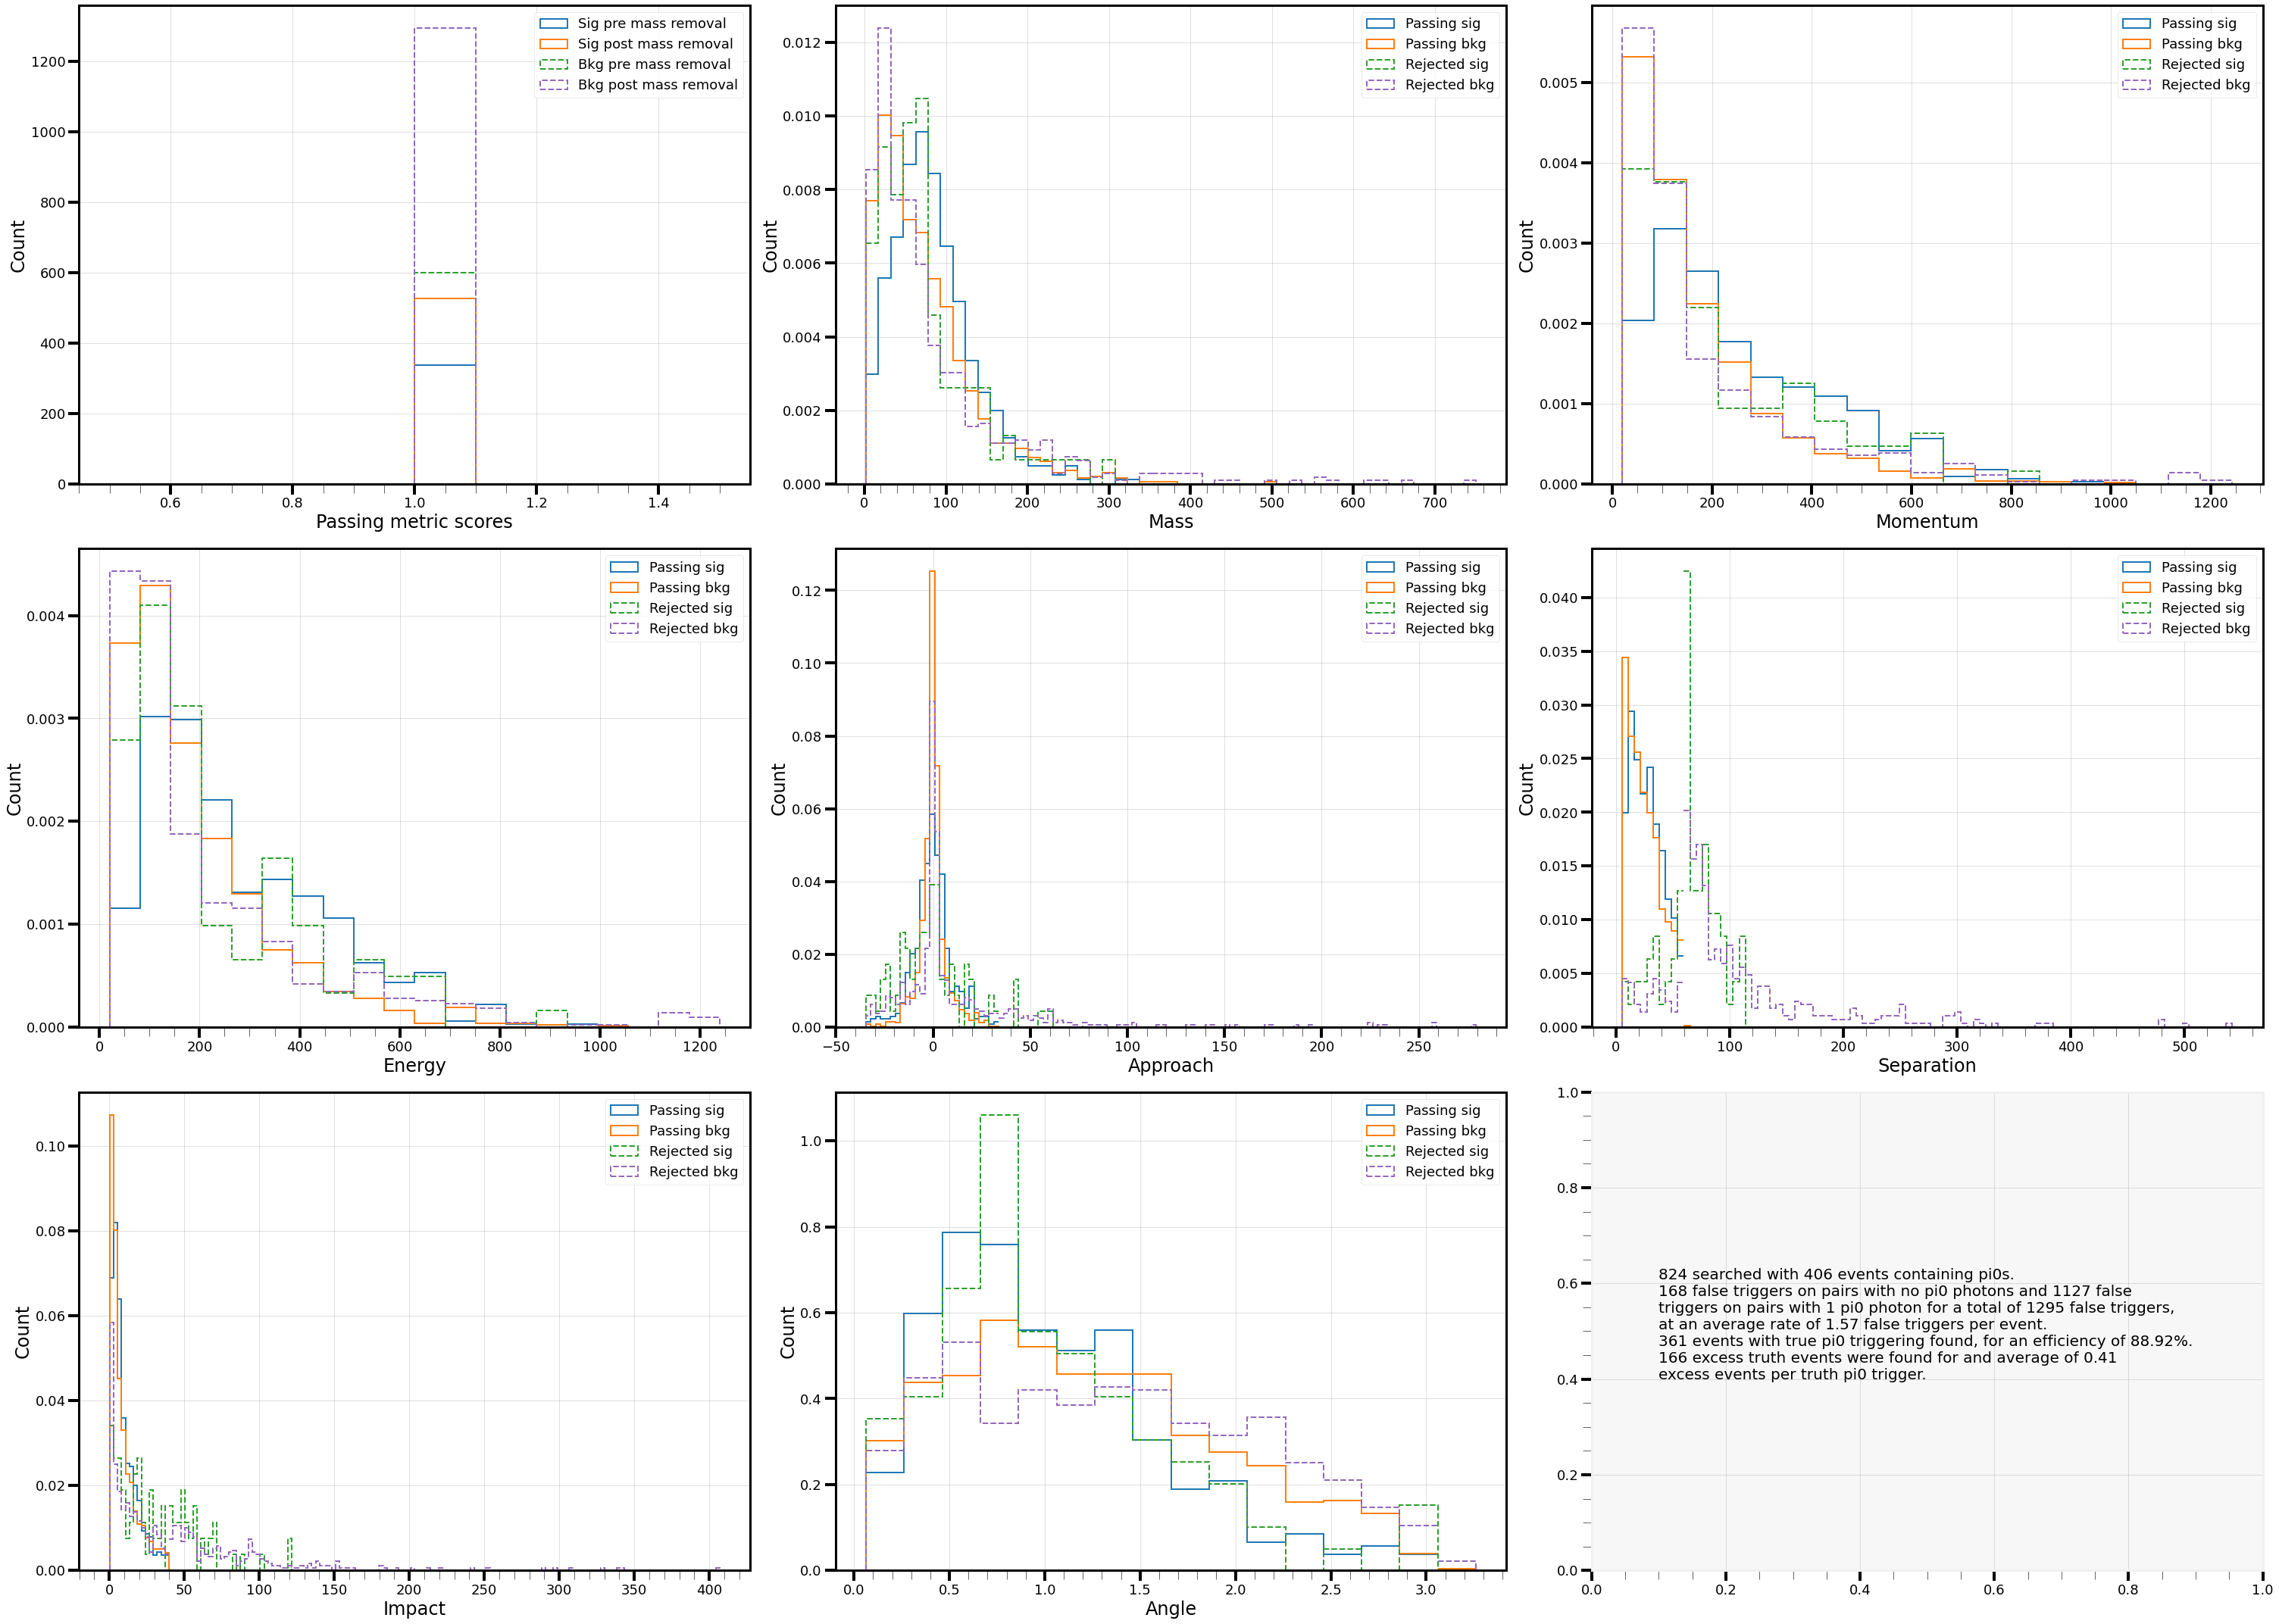

/software/wx21978/miniconda/envs/pi0-phys/lib/python3.10/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: divide by zero encountered in true_divide
  return n/db/n.sum(), bin_edges
/software/wx21978/miniconda/envs/pi0-phys/lib/python3.10/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: divide by zero encountered in true_divide
  return n/db/n.sum(), bin_edges
/software/wx21978/miniconda/envs/pi0-phys/lib/python3.10/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: divide by zero encountered in true_divide
  return n/db/n.sum(), bin_edges
/software/wx21978/miniconda/envs/pi0-phys/lib/python3.10/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
/software/wx21978/miniconda/envs/pi0-phys/lib/python3.10/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
/software/wx21978/miniconda/envs/pi0-phys/lib/p

pre
post
pre
post
pre
post


/software/wx21978/miniconda/envs/pi0-phys/lib/python3.10/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: divide by zero encountered in true_divide
  return n/db/n.sum(), bin_edges
/software/wx21978/miniconda/envs/pi0-phys/lib/python3.10/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
/software/wx21978/miniconda/envs/pi0-phys/lib/python3.10/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
/software/wx21978/miniconda/envs/pi0-phys/lib/python3.10/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: divide by zero encountered in true_divide
  return n/db/n.sum(), bin_edges
/software/wx21978/miniconda/envs/pi0-phys/lib/python3.10/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
/software/wx21978/miniconda/envs/pi0-phys/lib/py

pre
post
pre
post
pre
post


/software/wx21978/miniconda/envs/pi0-phys/lib/python3.10/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: divide by zero encountered in true_divide
  return n/db/n.sum(), bin_edges
/software/wx21978/miniconda/envs/pi0-phys/lib/python3.10/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
/software/wx21978/miniconda/envs/pi0-phys/lib/python3.10/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
/software/wx21978/miniconda/envs/pi0-phys/lib/python3.10/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
/software/wx21978/miniconda/envs/pi0-phys/lib/python3.10/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: divide by zero encountered in true_divide
  return n/db/n.sum(), bin_edges
/software/wx21978/miniconda/envs/pi0-phys/lib/py

pre
post


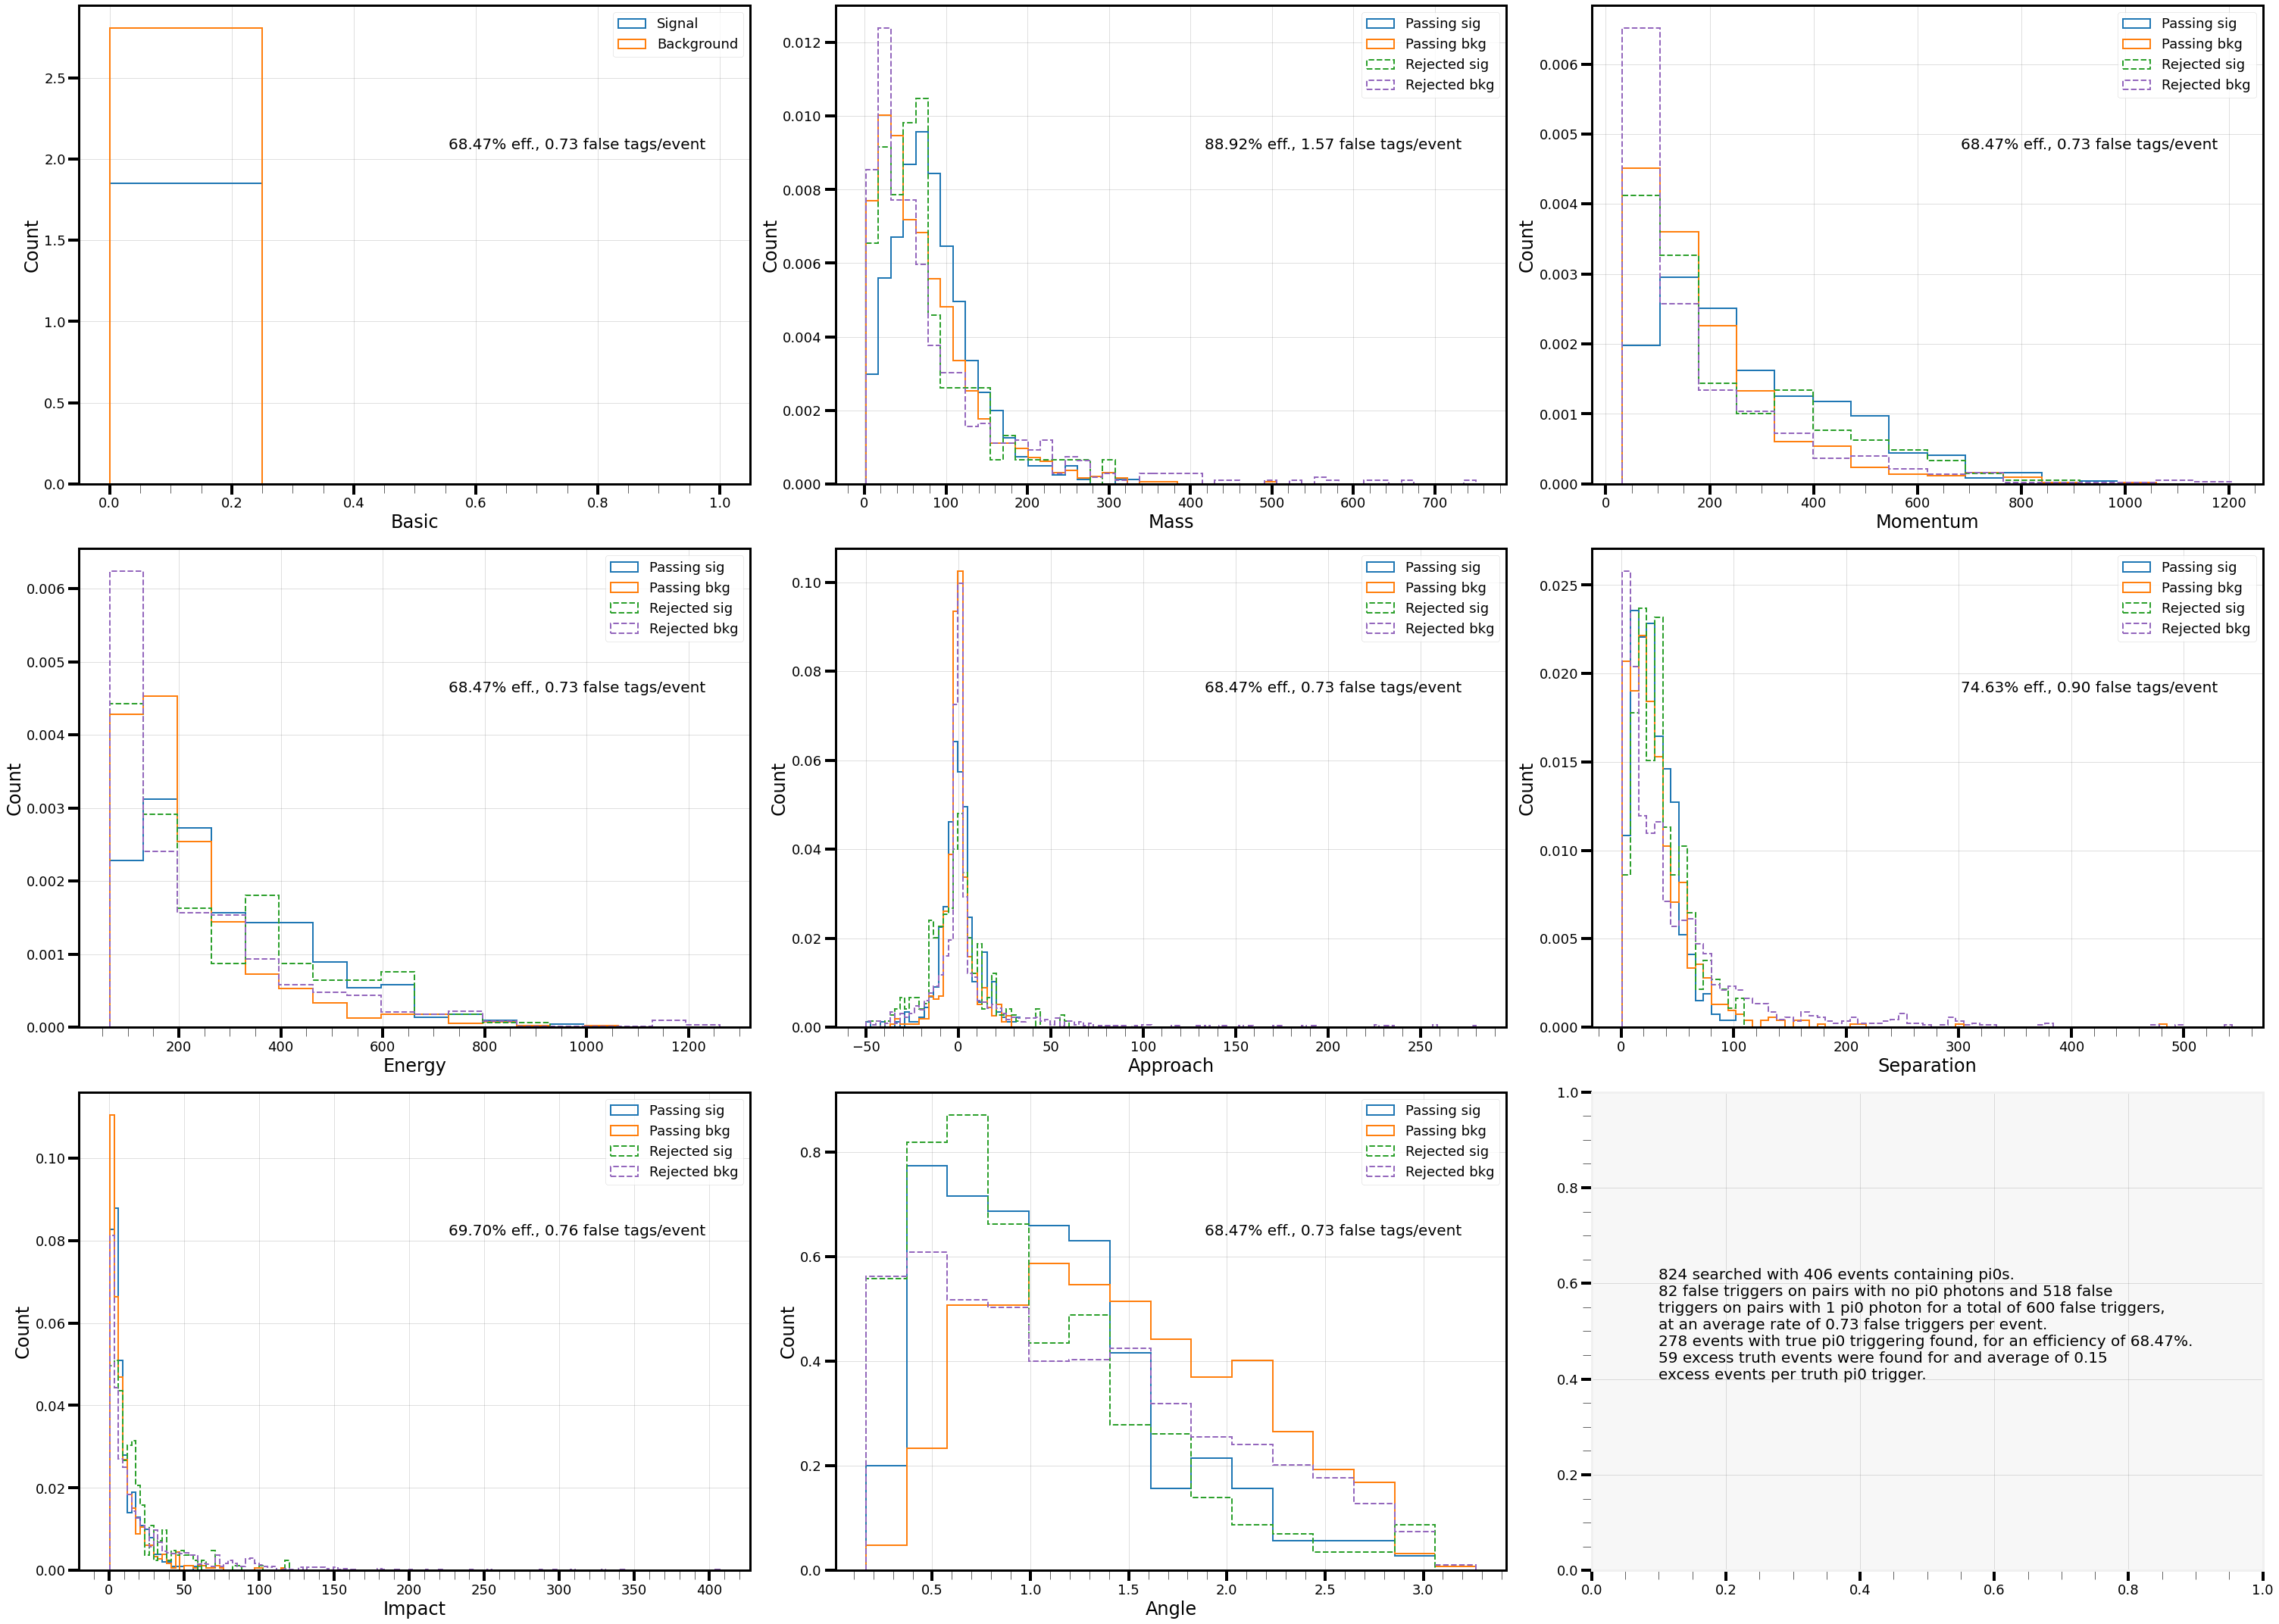

In [28]:
selectors = SelectorEvaluator(evts, pair_coords, sig_count)
selectors.add_metric("basic", selectors.wrap_metric_arguments(init_cut_metric))

selectors.make_n_minus_1_summary("basic", "mass")
selectors.make_n_minus_1_per_property("basic")

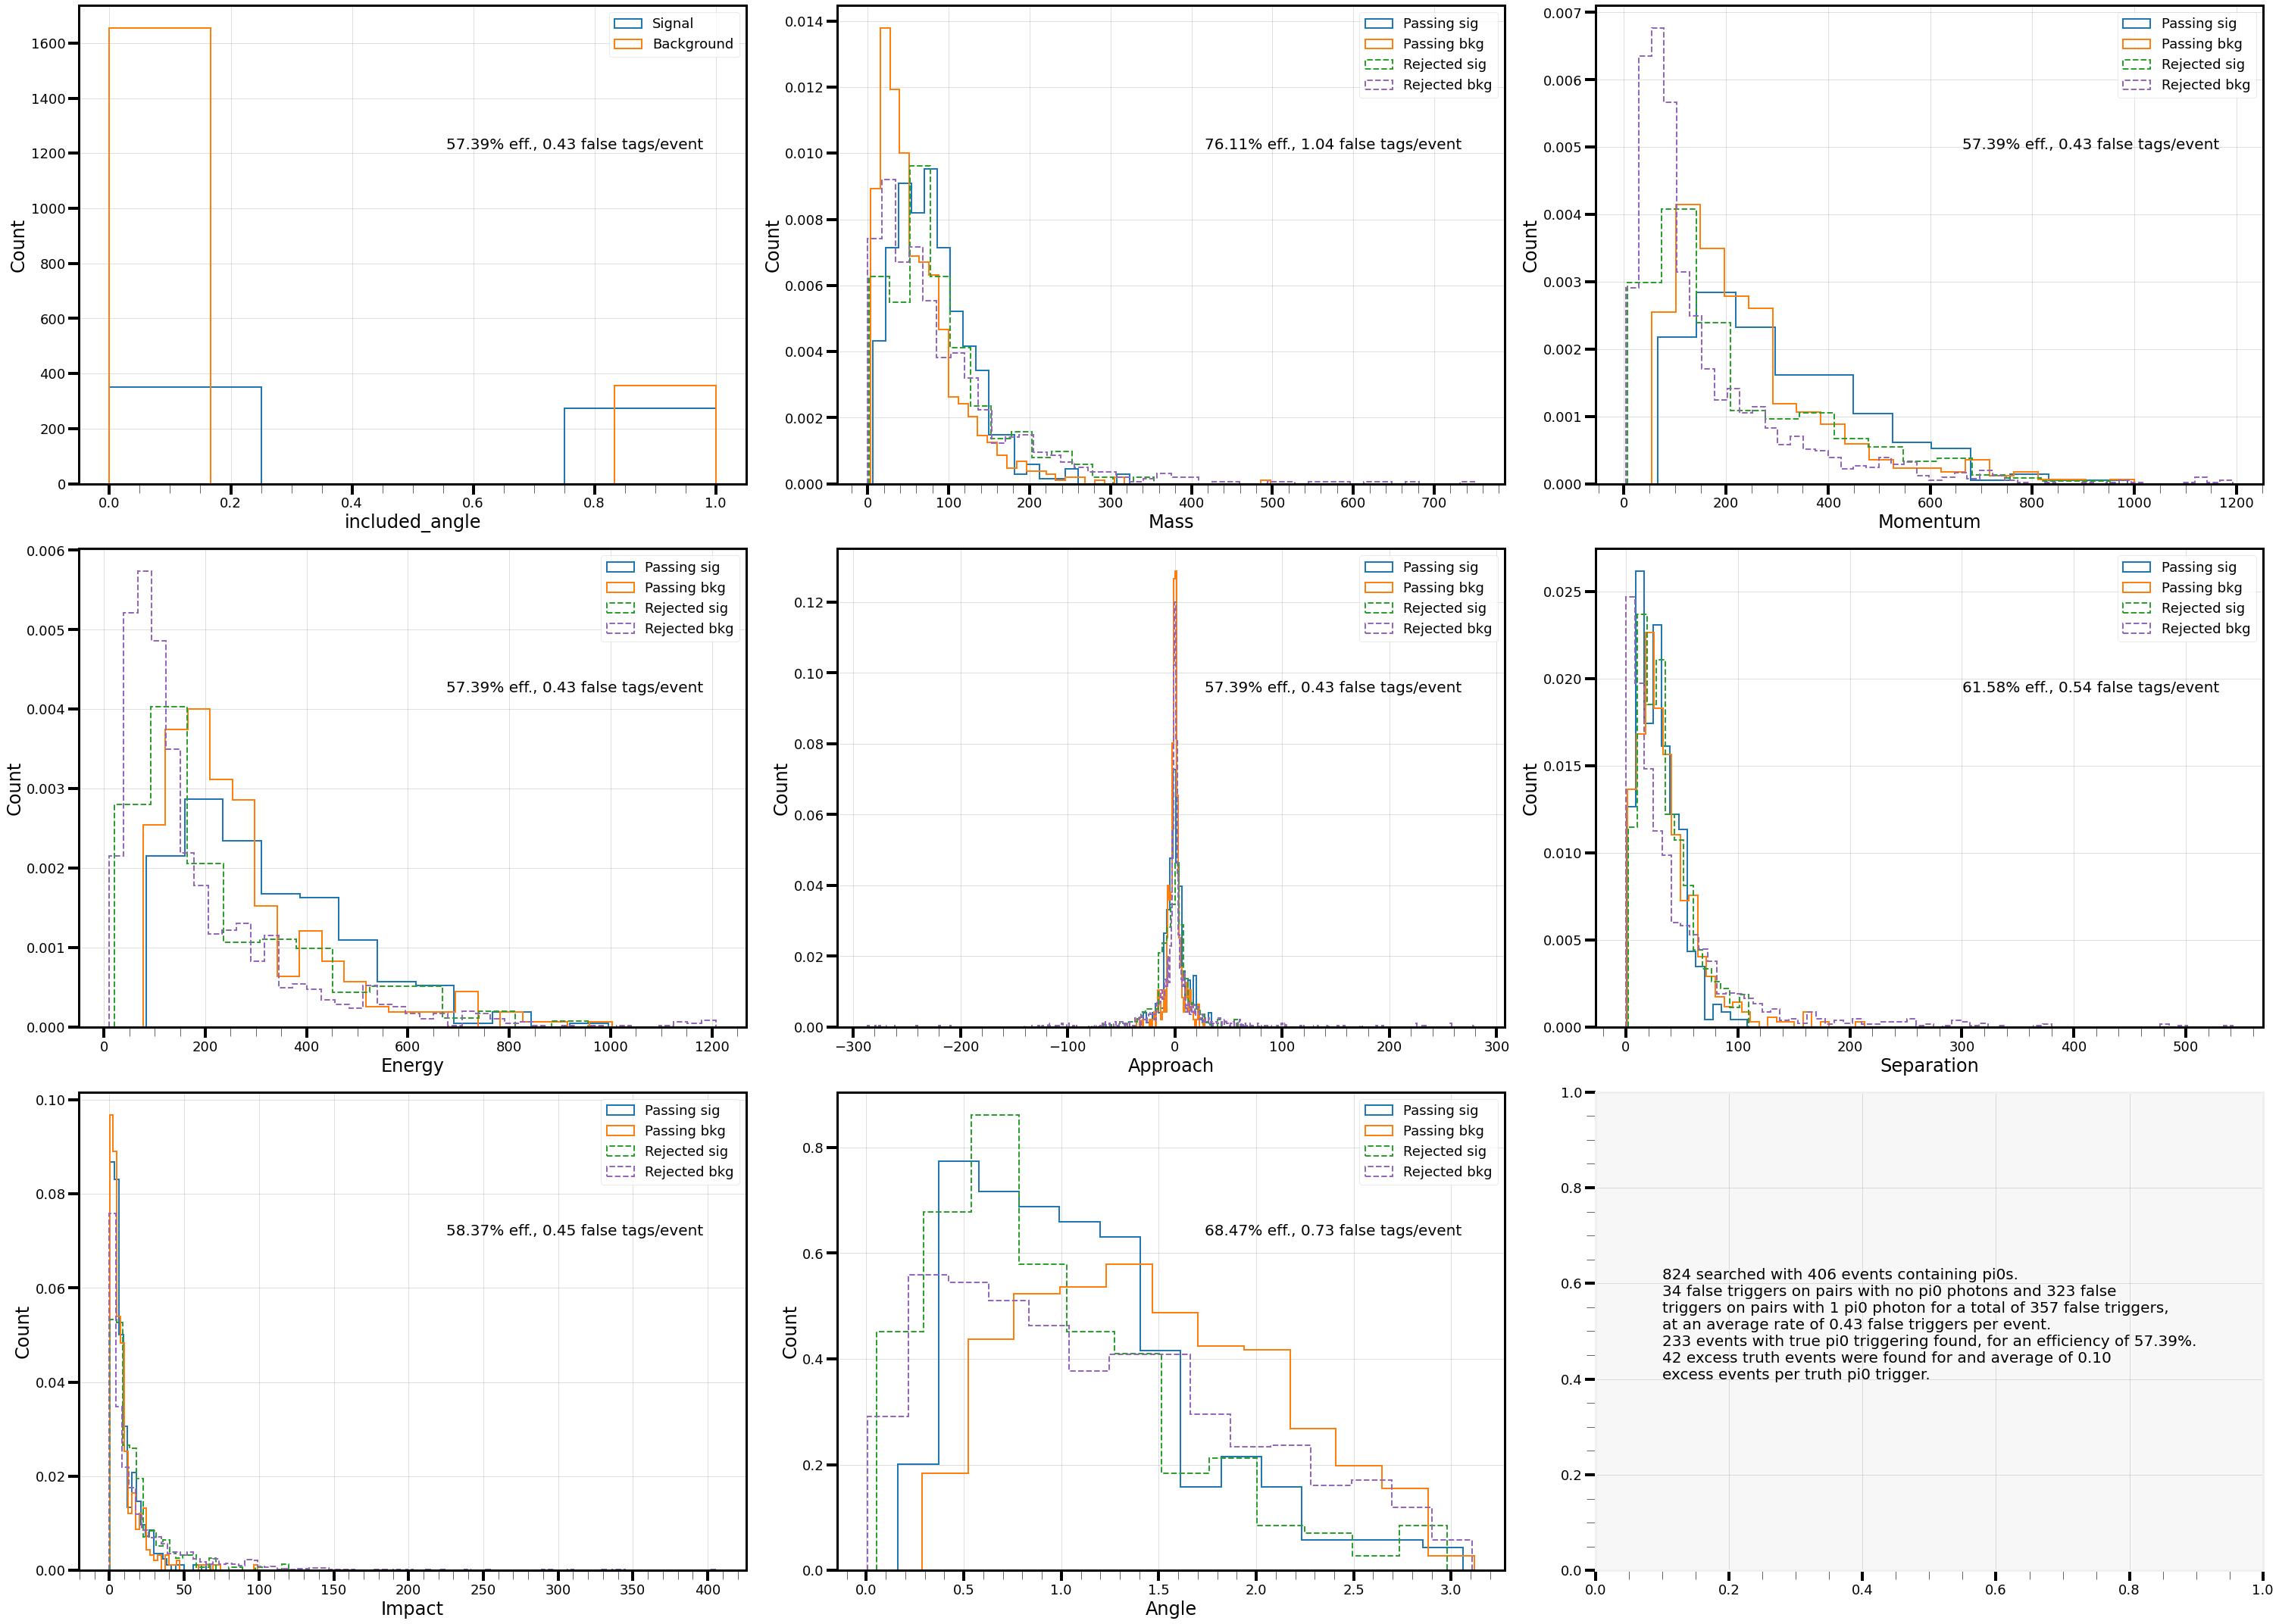

In [ ]:
selectors.add_metric("included_angle", selectors.wrap_metric_arguments(cut_metric_generator(mass_cuts=(50,150), approach_cuts=40, impact_cuts=40, separation_cuts=(5,60), angle_cuts=(0.2, np.pi/2))))

selectors.make_n_minus_1_per_property("included_angle")

/software/wx21978/miniconda/envs/pi0-phys/lib/python3.10/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: divide by zero encountered in true_divide
  return n/db/n.sum(), bin_edges
/software/wx21978/miniconda/envs/pi0-phys/lib/python3.10/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: divide by zero encountered in true_divide
  return n/db/n.sum(), bin_edges
/software/wx21978/miniconda/envs/pi0-phys/lib/python3.10/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: divide by zero encountered in true_divide
  return n/db/n.sum(), bin_edges
/software/wx21978/miniconda/envs/pi0-phys/lib/python3.10/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
/software/wx21978/miniconda/envs/pi0-phys/lib/python3.10/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
/software/wx21978/miniconda/envs/pi0-phys/lib/p

pre
post
pre
post
pre
post


/software/wx21978/miniconda/envs/pi0-phys/lib/python3.10/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
/software/wx21978/miniconda/envs/pi0-phys/lib/python3.10/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
/software/wx21978/miniconda/envs/pi0-phys/lib/python3.10/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: divide by zero encountered in true_divide
  return n/db/n.sum(), bin_edges
/software/wx21978/miniconda/envs/pi0-phys/lib/python3.10/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
/software/wx21978/miniconda/envs/pi0-phys/lib/python3.10/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: divide by zero encountered in true_divide
  return n/db/n.sum(), bin_edges
/software/wx21978/miniconda/envs/pi0-phys/lib/py

pre
post
pre
post
pre
post


/software/wx21978/miniconda/envs/pi0-phys/lib/python3.10/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: divide by zero encountered in true_divide
  return n/db/n.sum(), bin_edges
/software/wx21978/miniconda/envs/pi0-phys/lib/python3.10/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
/software/wx21978/miniconda/envs/pi0-phys/lib/python3.10/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: divide by zero encountered in true_divide
  return n/db/n.sum(), bin_edges
/software/wx21978/miniconda/envs/pi0-phys/lib/python3.10/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


pre
post


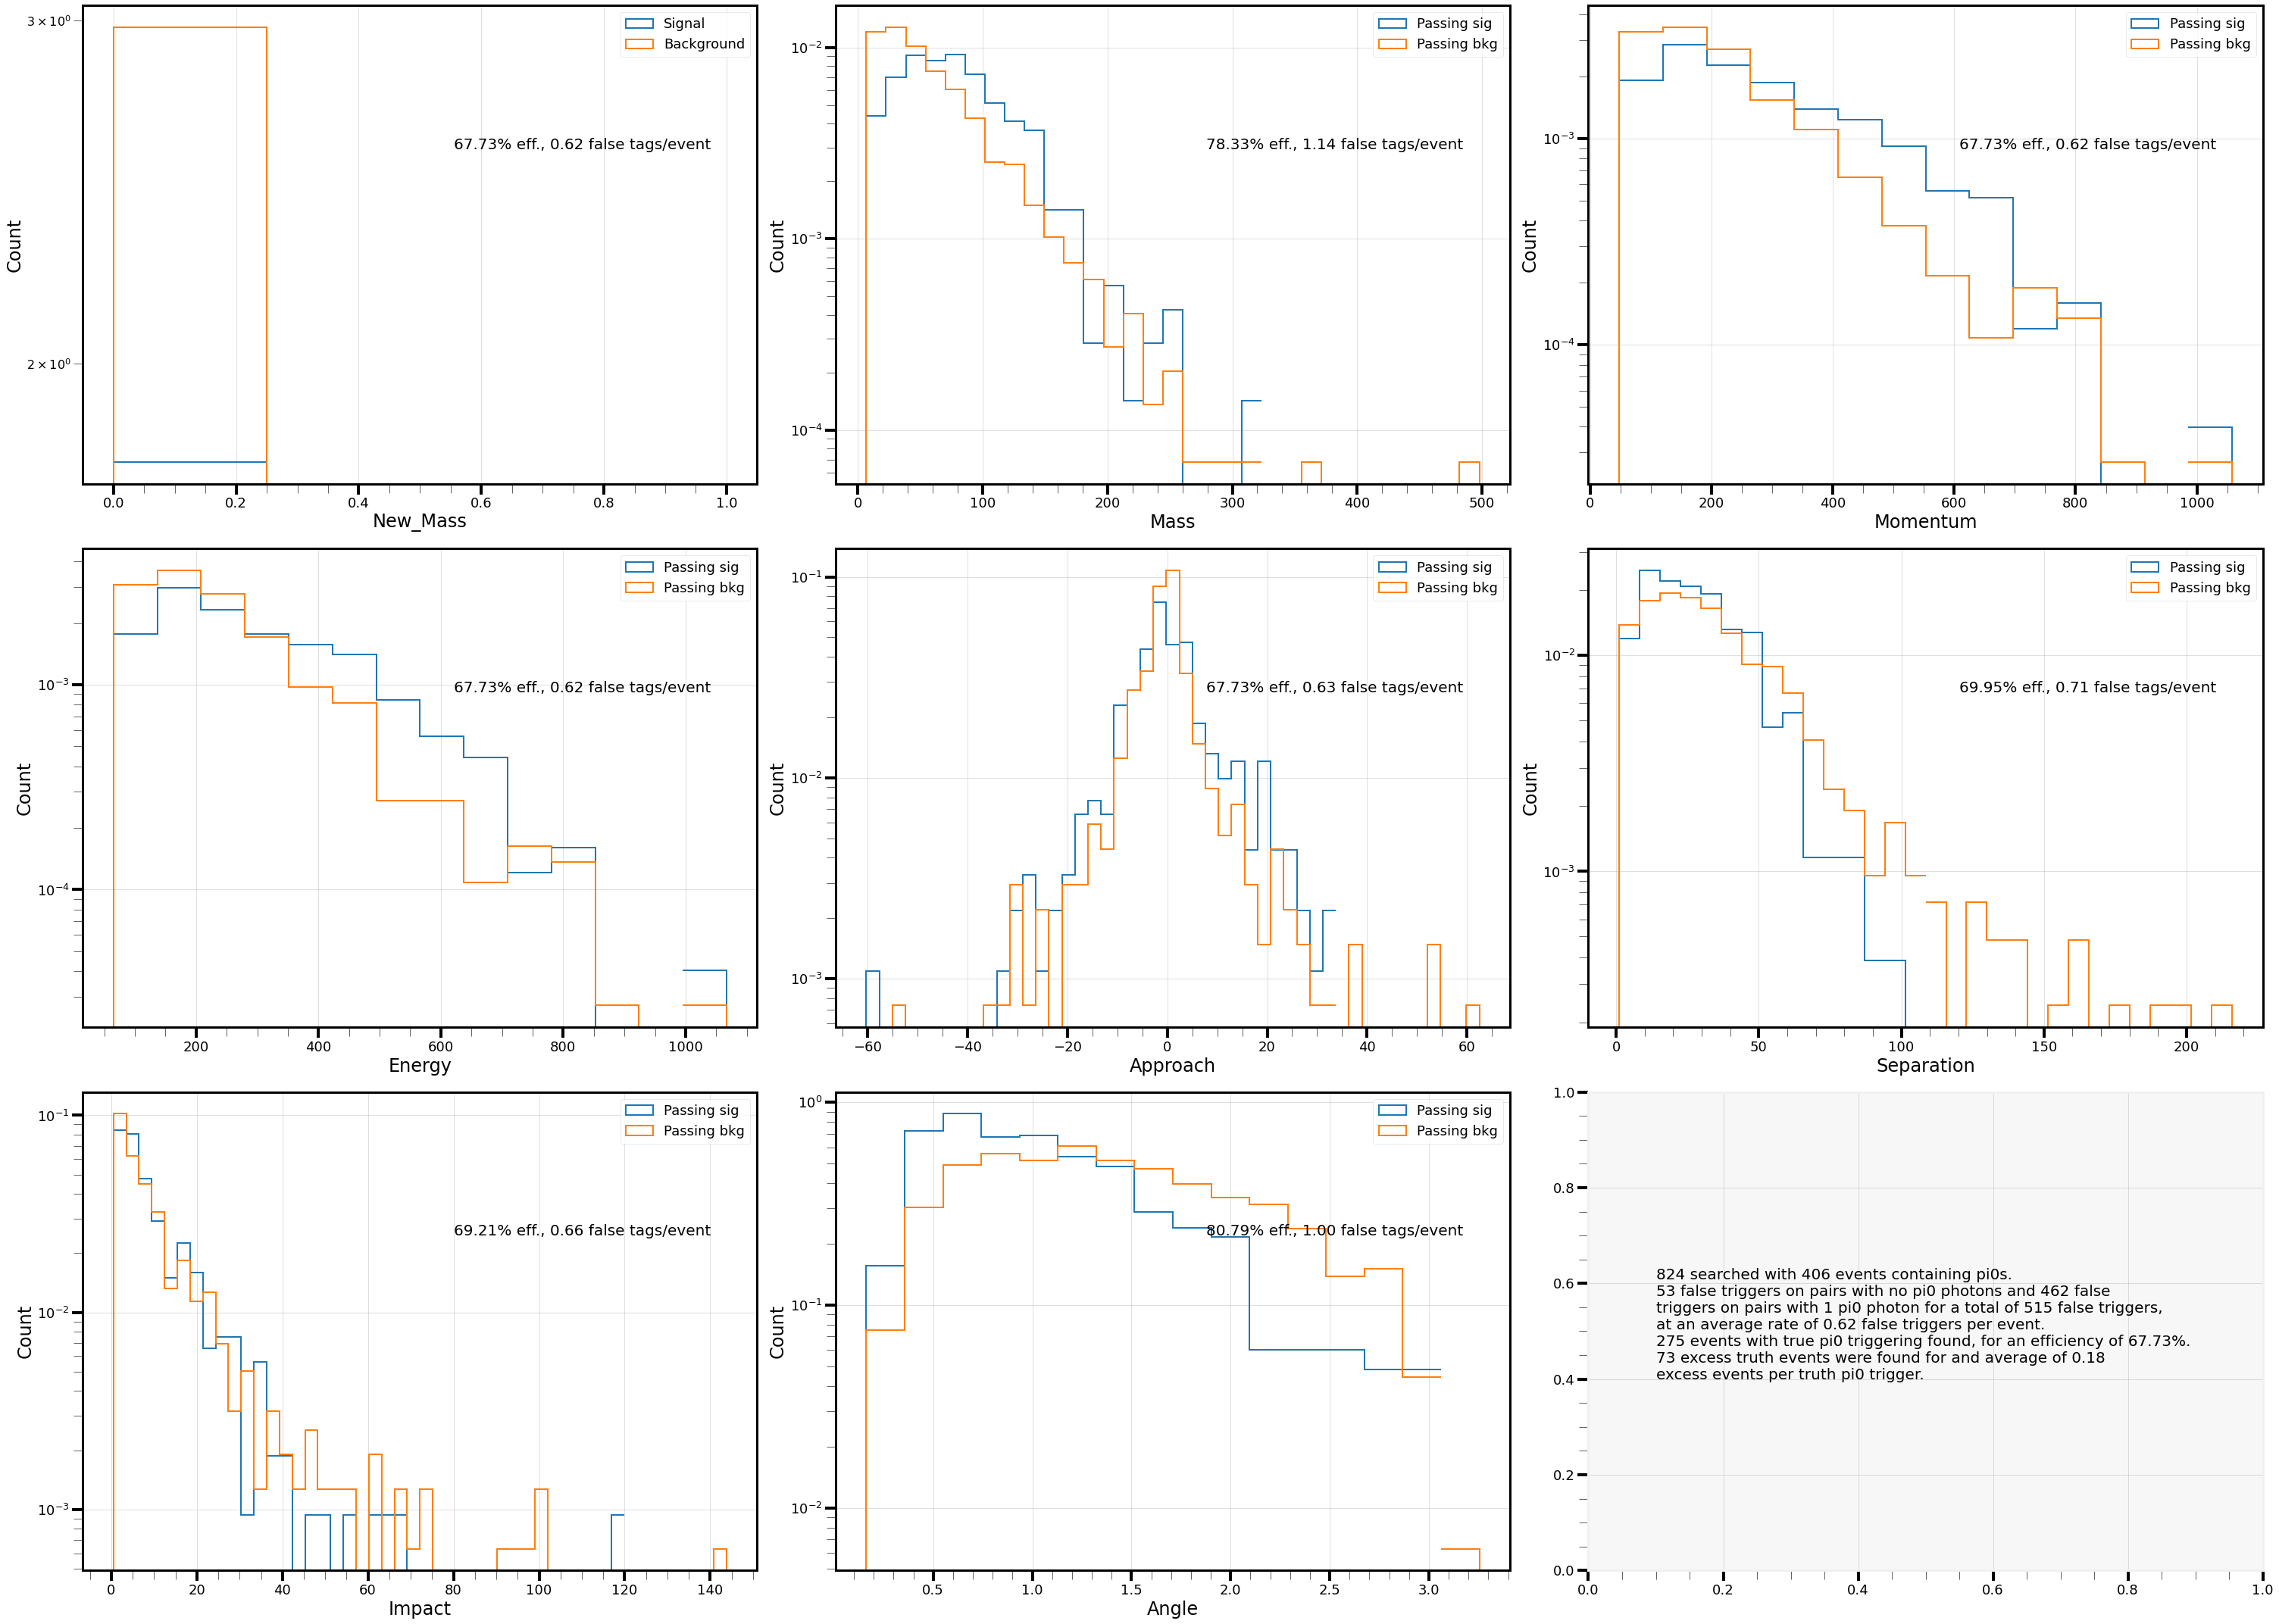

In [30]:
selectors.add_metric("new_mass", selectors.wrap_metric_arguments(cut_metric_generator(mass_cuts=(40,180), approach_cuts=40, impact_cuts=40, separation_cuts=(5,80), angle_cuts=(0.2, np.pi/2))))

selectors.make_n_minus_1_per_property("new_mass", style="display")

/software/wx21978/miniconda/envs/pi0-phys/lib/python3.10/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: divide by zero encountered in true_divide
  return n/db/n.sum(), bin_edges
/software/wx21978/miniconda/envs/pi0-phys/lib/python3.10/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: divide by zero encountered in true_divide
  return n/db/n.sum(), bin_edges
/software/wx21978/miniconda/envs/pi0-phys/lib/python3.10/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: divide by zero encountered in true_divide
  return n/db/n.sum(), bin_edges
/software/wx21978/miniconda/envs/pi0-phys/lib/python3.10/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
/software/wx21978/miniconda/envs/pi0-phys/lib/python3.10/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: divide by zero encountered in true_divide
  return n/db/n.sum(), bin_edges
/software/wx21978/miniconda/envs/pi0-phys/lib/

pre
post
pre
post
pre
post


/software/wx21978/miniconda/envs/pi0-phys/lib/python3.10/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: divide by zero encountered in true_divide
  return n/db/n.sum(), bin_edges
/software/wx21978/miniconda/envs/pi0-phys/lib/python3.10/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
/software/wx21978/miniconda/envs/pi0-phys/lib/python3.10/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: divide by zero encountered in true_divide
  return n/db/n.sum(), bin_edges
/software/wx21978/miniconda/envs/pi0-phys/lib/python3.10/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
/software/wx21978/miniconda/envs/pi0-phys/lib/python3.10/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: divide by zero encountered in true_divide
  return n/db/n.sum(), bin_edges
/software/wx21978/miniconda/envs/pi0-phys/lib/p

pre
post
pre
post
pre
post


/software/wx21978/miniconda/envs/pi0-phys/lib/python3.10/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: divide by zero encountered in true_divide
  return n/db/n.sum(), bin_edges
/software/wx21978/miniconda/envs/pi0-phys/lib/python3.10/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: divide by zero encountered in true_divide
  return n/db/n.sum(), bin_edges
/software/wx21978/miniconda/envs/pi0-phys/lib/python3.10/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


pre
post


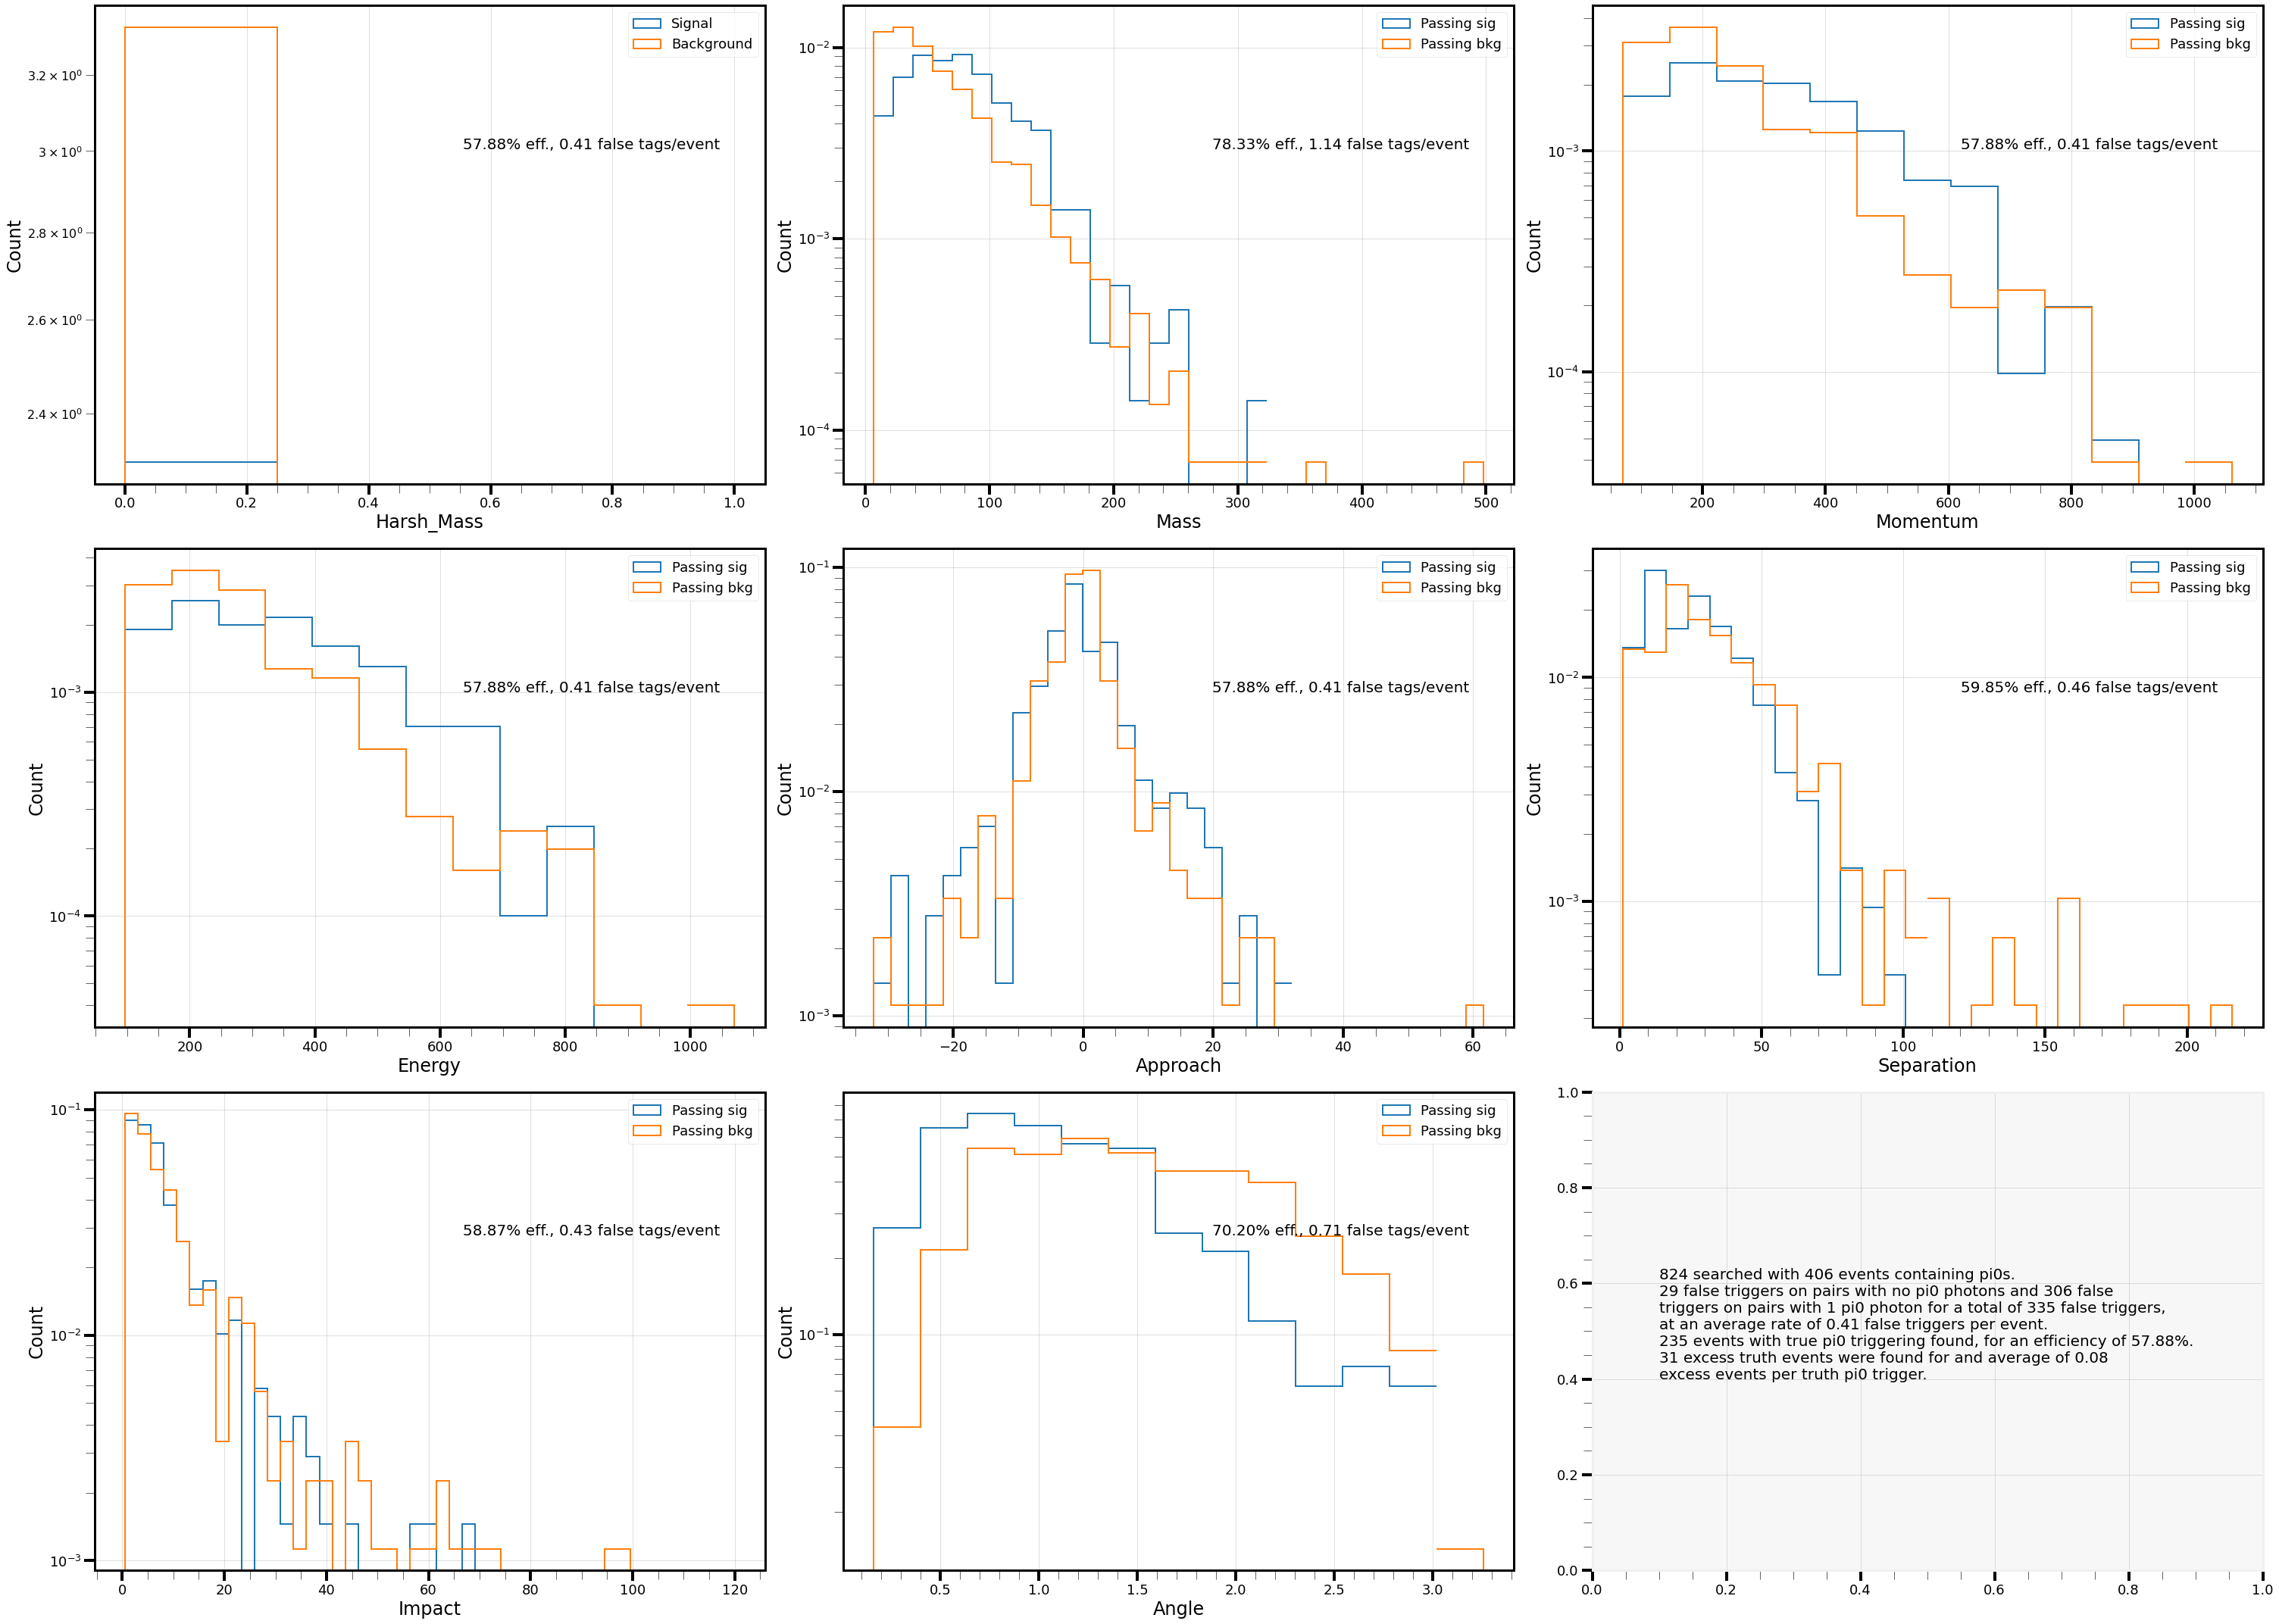

In [31]:
selectors.add_metric("harsh_mass", selectors.wrap_metric_arguments(cut_metric_generator(mass_cuts=(60,180), approach_cuts=40, impact_cuts=40, separation_cuts=(5,80), angle_cuts=(0.2, np.pi/2))))

selectors.make_n_minus_1_per_property("harsh_mass", style="display")

In [20]:
def comb_metric(mass, momentum, energy, approach, separation, impact, angle):
    initial_offset = 100
    
    approach_divisor = 0.01
    separation_divisor = 0.01
    impact_divisor = 0.01

    geometry_metric = np.exp( - approach**2/approach_divisor - separation**2/separation_divisor - impact**2/impact_divisor)

    # geometry_metric = geometry_metric * np.sin(angle)**2

    mass_mean = 110
    mass_sigma = 30

    energy_metric = np.exp(-(mass-mass_mean)**2/mass_sigma)
    energy_metric=1
    
    return np.exp(initial_offset) * geometry_metric * energy_metric

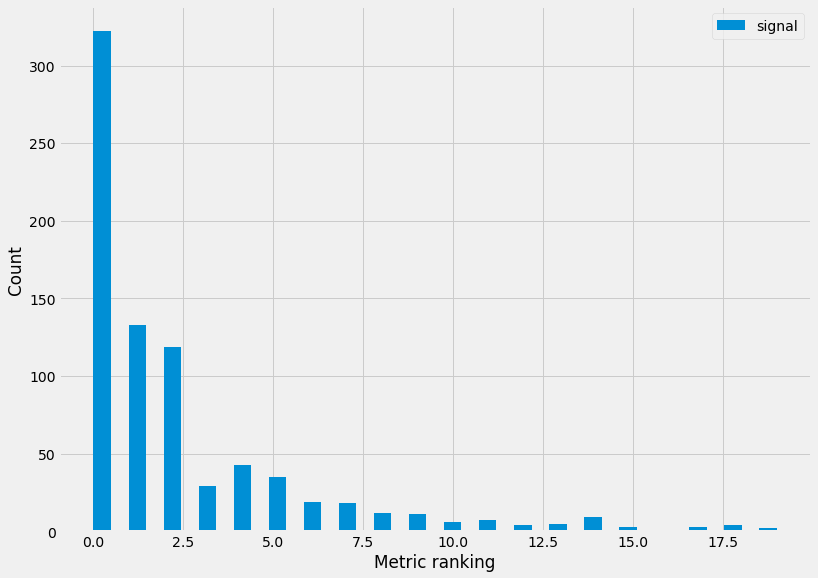

0.3640776699029126


In [31]:
metric_rank = ak.argsort(comb_metric(masses, momenta, energies, approaches, separations, impacts, angles), ascending=True)[truth_mask]

plot_rank_hist_nb("Metric", metric_rank, y_scaling='linear')

print(np.sum(metric_rank == 0)/ak.num(metric_rank, axis=0))

ValueError: in ListOffsetArray64, cannot convert to RegularArray because subarray lengths are not regular

(https://github.com/scikit-hep/awkward-1.0/blob/1.8.0/src/cpu-kernels/awkward_ListOffsetArray_toRegularArray.cpp#L22)

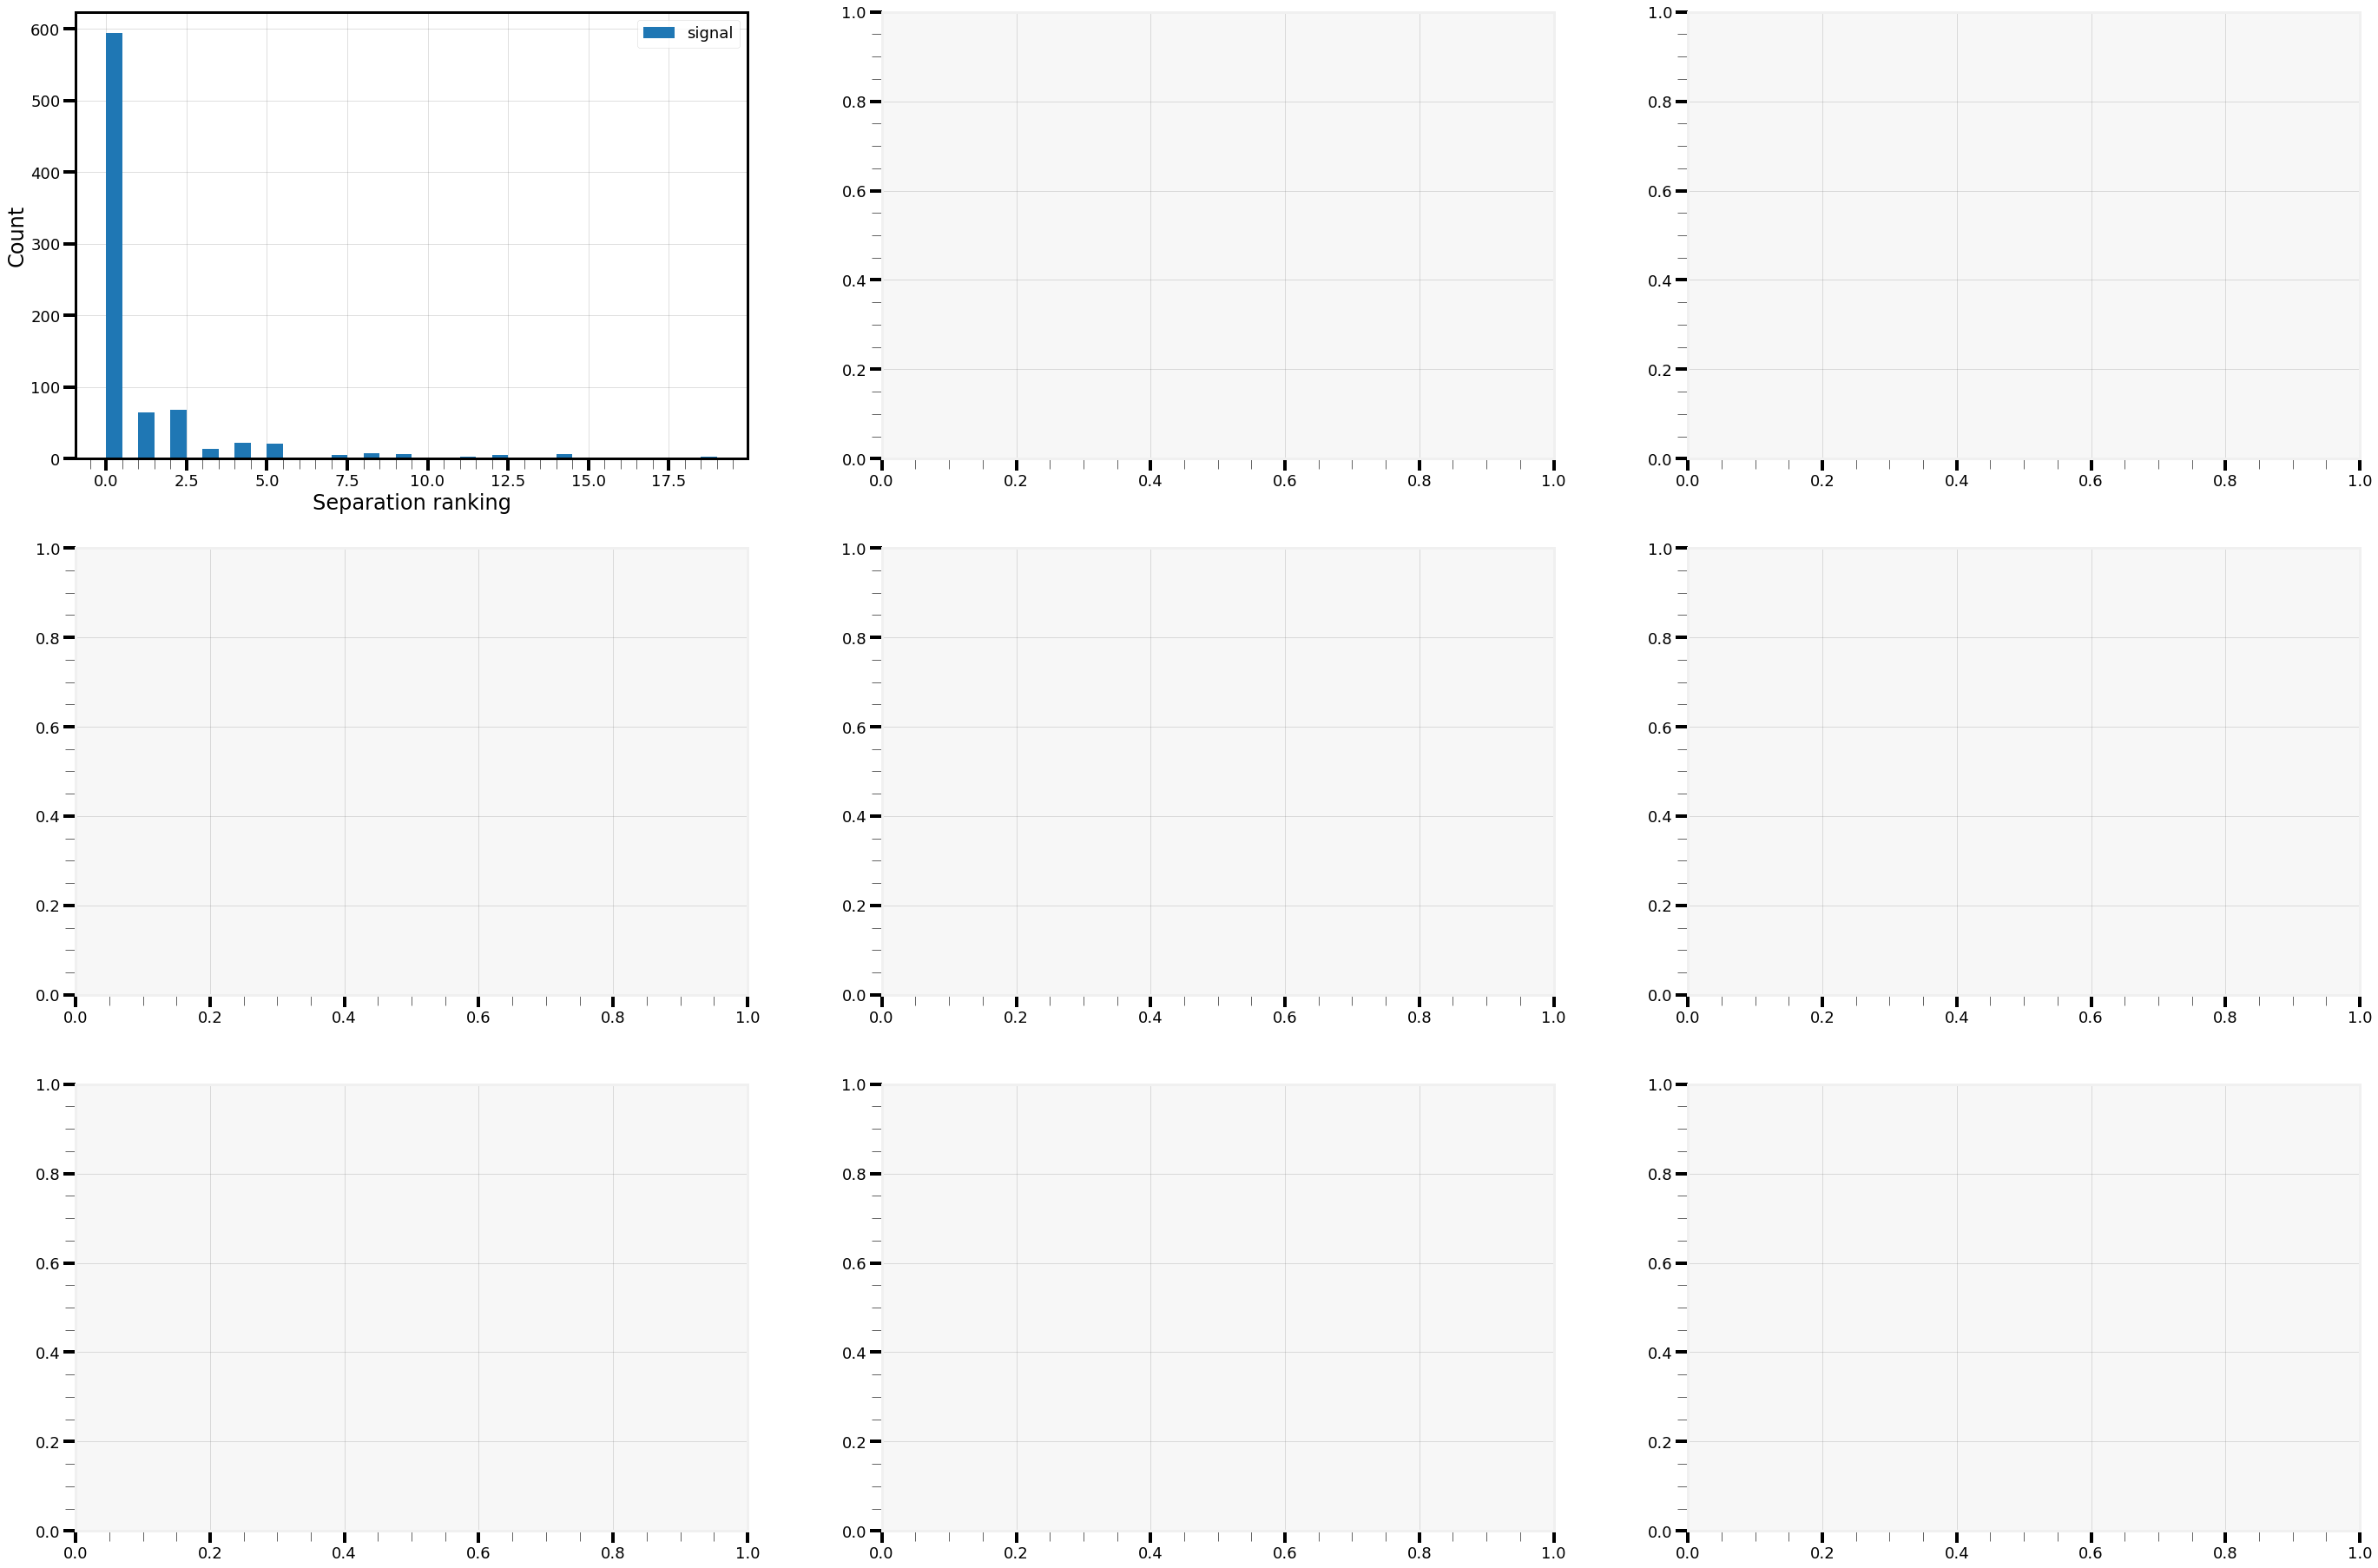

In [32]:
def metric_generator(prop_name):
    def metric(properties):
        divisor = 10
        return np.exp(abs(properties[prop_name]) /divisor)
    return metric

def geo_metric(properties):
    initial_offset = 3
    
    approach_divisor = 10
    separation_divisor = 10
    impact_divisor = 10
    
    angle_metric = np.cos((properties["angle"]-np.pi/16)/0.75)

    geometry_metric = np.exp(- initial_offset + abs(properties["approach"])/approach_divisor + abs(properties["separation"])/separation_divisor + abs(properties["impact"])/impact_divisor)
    
    return geometry_metric * np.exp(-angle_metric)

def geo_metric_angle(properties):
    angle_metric = np.cos((properties["angle"]-np.pi/16)/0.75)
    
    return geo_metric(properties) * np.exp(-angle_metric)

metrics = RankEvaluator(evts, pair_coords, sig_count)

metrics.add_metric("separation", metric_generator("separation"))
metrics.add_metric("geometric", geo_metric)
metrics.add_metric("geo_ang", geo_metric_angle)

# Add distribution of metric itself
metrics.make_summary_plot("separation")
metrics.make_summary_plot("geometric")
metrics.make_summary_plot("geo_ang")

[False False False  True False False  True False  True False False False
  True False False False False  True  True False  True False False False
 False  True  True False False False False  True False False False False
  True False False  True False  True  True  True False False  True False
 False False  True False False False  True False  True  True False False
  True False False False  True False False  True False False False False
  True False False  True False False False False False False  True False
 False False  True  True  True False False  True False  True False False
  True False  True  True  True  True False False  True False  True False
 False False False False False  True  True False False False False False
 False  True  True False  True False  True False False False  True  True
 False  True  True False False False False False False  True False False
 False False  True False False False  True False False False False  True
 False  True False False False False False  True Fa

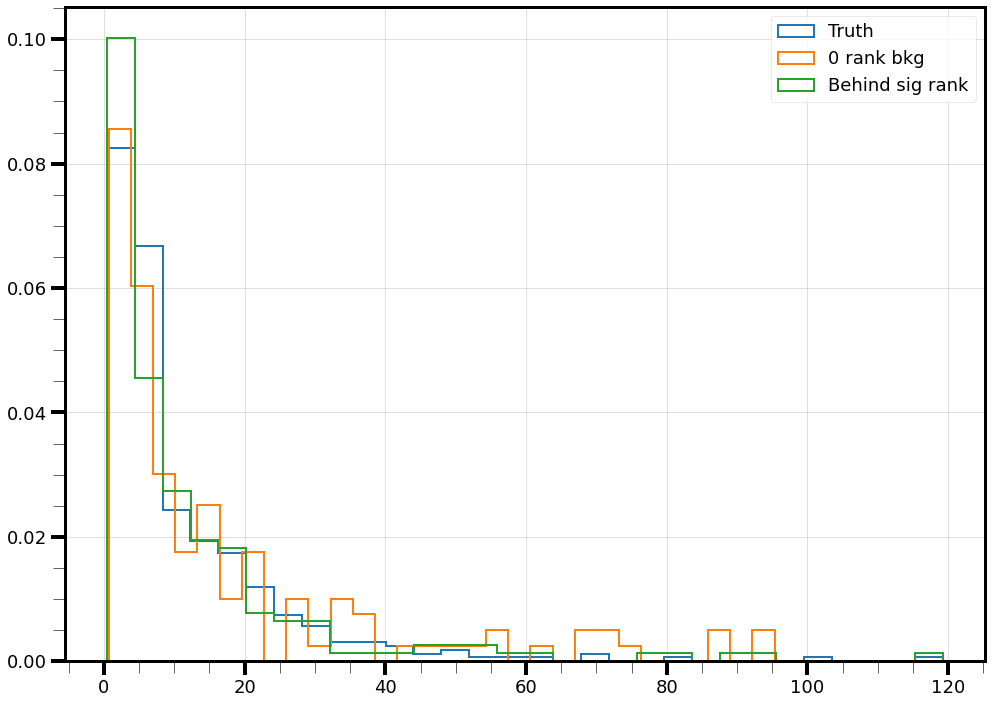

In [28]:
ranks = ak.argsort(comb_metric(masses, momenta, energies, approaches, separations, impacts, angles), ascending=True)
bkg_ranks = ranks[np.logical_not(truth_mask)]

def get_second_rank(property):
    non_first_sig_events = np.logical_not(ranks[truth_mask] == 0).to_numpy()[:,0]
    print(non_first_sig_events)
    return

second_ranked = get_second_rank(impacts)

plt_conf.setup_figure()
plt.hist(impacts[truth_mask], **plt_conf.gen_kwargs(type="hist", density=True, label="Truth", bins=30))#plt_conf.get_bins(impacts[truth_mask])))
plt.hist(ak.pad_none(impacts[bkg_ranks == 0], 1, axis=1).to_numpy(), **plt_conf.gen_kwargs(type="hist", density=True, label="0 rank bkg", index=1, bins=30))#plt_conf.get_bins(ak.pad_none(impacts[bkg_ranks == 0], 1, axis=1).to_numpy())))

plt.hist(ak.pad_none(impacts[bkg_ranks == 1], 1, axis=1).to_numpy(), **plt_conf.gen_kwargs(type="hist", density=True, label="Behind sig rank", index=2, bins=30))
plt_conf.format_axis()
plt_conf.end_plot()

In [102]:
print(results)
print(np.max(results))
print(np.where(results == np.max(results)))

[[[[0.68811881 0.18069307 0.06188119]
   [0.68811881 0.18069307 0.06188119]
   [0.68811881 0.18069307 0.06188119]
   [0.68811881 0.18069307 0.06188119]
   [0.68811881 0.18069307 0.06188119]
   [0.68811881 0.18069307 0.06188119]
   [0.68811881 0.18069307 0.06188119]
   [0.68811881 0.18069307 0.06188119]]

  [[0.68811881 0.18069307 0.05940594]
   [0.68564356 0.17821782 0.06188119]
   [0.68564356 0.17821782 0.06188119]
   [0.68564356 0.17821782 0.06188119]
   [0.68564356 0.17821782 0.06188119]
   [0.68564356 0.17821782 0.06188119]
   [0.68564356 0.17821782 0.06188119]
   [0.68564356 0.17821782 0.06188119]]

  [[0.68811881 0.18069307 0.05940594]
   [0.68564356 0.17821782 0.06188119]
   [0.68564356 0.17821782 0.06188119]
   [0.68564356 0.17821782 0.06188119]
   [0.68564356 0.17821782 0.06188119]
   [0.68564356 0.17821782 0.06188119]
   [0.68564356 0.17821782 0.06188119]
   [0.68564356 0.17821782 0.06188119]]

  [[0.68811881 0.18069307 0.05940594]
   [0.68564356 0.17821782 0.06188119]
   [0.

In [ ]:
# WTH is this you ****ing moron... Use something iterable for forming the polynomials...

def comb_metric_polynomial_sum(mass, m_0, m_1, m_2, m_3, m_4, angle, ang_0, ang_1, ang_2, ang_3, ang_4, approach, a_0, a_1, a_2, a_3, a_4, separation, s_0, s_1, s_2, s_3, s_4, impact, i_0, i_1, i_2, i_3, i_4):
    mass_metric     = m_0 + m_1 * mass       + m_2 * mass**2       + m_3 * mass**3       + m_4 * mass**4
    approach_metric =       a_1 * approach   + a_2 * approach**2   + a_3 * approach**3   + a_4 * approach**4
    separation_metric =     s_1 * separation + s_2 * separation**2 + s_3 * separation**3 + s_4 * separation**4
    impact_metric   =       i_1 * impact     + i_2 * impact**2     + i_3 * impact**3     + i_4 * impact**4
    angle_metric    =       ang_1 * angle    + ang_2 * angle**2    + ang_3 * angle**3    + ang_4 * angle**4

    return mass_metric + approach_metric + separation_metric + impact_metric + angle_metric

def comb_metric_polynomial_mult(mass, m_0, m_1, m_2, m_3, m_4, angle, ang_0, ang_1, ang_2, ang_3, ang_4, approach, a_0, a_1, a_2, a_3, a_4, separation, s_0, s_1, s_2, s_3, s_4, impact, i_0, i_1, i_2, i_3, i_4):
    mass_metric     = m_0 + m_1 * mass       + m_2 * mass**2       + m_3 * mass**3       + m_4 * mass**4
    approach_metric = a_0 + a_1 * approach   + a_2 * approach**2   + a_3 * approach**3   + a_4 * approach**4
    separation_metric =s_0+ s_1 * separation + s_2 * separation**2 + s_3 * separation**3 + s_4 * separation**4
    impact_metric   = i_0 + i_1 * impact     + i_2 * impact**2     + i_3 * impact**3     + i_4 * impact**4
    angle_metric    =ang_0+ ang_1 * angle    + ang_2 * angle**2    + ang_3 * angle**3    + ang_4 * angle**4

    return mass_metric * approach_metric * separation_metric * impact_metric * angle_metric

def get_pos_frac(approach_div, sep_div, impact_div, position=0):
    metric_rank = ak.argsort(comb_metric_iterate(approaches, separations, impacts, approach_divisor=approach_div, separation_divisor=sep_div, impact_divisor=impact_div), ascending=True)[truth_mask]
    
    if isinstance(position, int):
        return np.sum(metric_rank == position)/ak.num(metric_rank, axis=0)
    else:
        results = np.zeros_like(position, dtype=float)
        num_vals = ak.num(metric_rank, axis=0)
        for i, p in enumerate(position):
            results[i] = np.sum(metric_rank == p) / num_vals
        return results

In [ ]:
fig = plt.figure()
ax = Axes3D(fig)

